# Industry CAPM Regime Ambiguity

## Setup

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import scipy as sp
import pandas as pd

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot

In [19]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [20]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [21]:
%matplotlib inline

## Data

Data is imported from [Kenneth French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and [FRED](https://fred.stlouisfed.org/series/). Currently, this workbook uses 49 industry portfolios and the FF3 factors. Additionally, NBER recession indicators complement the data.

### Industry data

In [31]:
industries_daily = data.download_industry_data('D', excessreturns=True)
industries_monthly = data.download_industry_data('M', excessreturns=True)

### Factor data

In [8]:
factors_daily = data.download_factor_data('D')
factors_monthly = data.download_factor_data('M')

### Recession data

In [9]:
usrec_daily = data.download_recessions_data('D')
usrec_monthly = data.download_recessions_data('M')

## Model

### Theory
The rationale for the model goes as follows:

Let $r^i_{t}$ and $r^M_{t}$ denote excess returns on an asset $i$ and the market portfolio. 

Investors use a standard CAPM to form expectations about means and variances of asset excess returns:
$$\mathbb{E}_t\big[r^i_{t+1}\big] = \alpha^i + \beta^i \, \mathbb{E}_t\big[r^{M}_{t+1}\big]$$
$$\mathbb{V}_t\big[r^i_{t+1}\big] = (\sigma^i)^2$$

Now suppose agents are ambiguous about the set of model-parameters that are generating next-period returns. In particular, there are two competing sets of parameters $\theta^i_{S_{t+1}} = \big(\alpha^i_{S_{t+1}}, \beta^i_{S_{t+1}}, \sigma^i_{S_{t+1}}\big)$, where $S_{t+1} \in \{0,1\}$, and the transition between the two sets of parameters follows a Markov process:

\begin{equation*}
    \begin{cases}
        r^i_{t+1} = \alpha^i_{S_{t+1}=0} + \beta^i_{S_{t+1}=0} \, \mathbb{E}_t\big[r^M_{t+1}\big] + \varepsilon^i_{t+1},  \quad\quad   \varepsilon^i_{t+1} \sim \mathcal{N}\big(0,(\sigma^i_{S_{t+1}=0})^2\big)\\
        r^i_{t+1} = \alpha^i_{S_{t+1}=1} + \beta^i_{S_{t+1}=1} \, \mathbb{E}_t\big[r^M_{t+1}\big] + \varepsilon^i_{t+1},  \quad\quad   \varepsilon^i_{t+1} \sim \mathcal{N}\big(0,(\sigma^i_{S_{t+1}=1})^2\big)
    \end{cases}
\end{equation*}

\begin{equation*}
    P\big(S^i_{t+1} = s^i_{t+1} \, \big| \, S^i_{t} = s^i_{t}\big) = 
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

Given the two-regime markov process, investors are ambiguous between two Gaussian distributions that next-period returns could be drawn from:
\begin{equation}
    \begin{cases}
        \phi_0(r^i_{t+1}) = \mathcal{N}\big(\mu^i_0 = \alpha^i_{0} + \beta^i_{0} \, \mathbb{E}_t\big[r^M_{t+1}\big],(\sigma^i_{0})^2\big), \quad \text{with probability } P_t(S^i_{t+1} = 0)\\
        \phi_1(r^i_{t+1}) = \mathcal{N}\big(\mu^i_1 = \alpha^i_{1} + \beta^i_{1} \, \mathbb{E}_t\big[r^M_{t+1}\big],(\sigma^i_{1})^2\big), \quad \text{with probability } P_t(S^i_{t+1} = 1) = \big[1-P_t(S^i_{t+1} = 0)\big]
    \end{cases}
\end{equation}
For both distributions, $\beta^i_{S_{t+1}}$ reflects the state-dependent level of systematic risk, while $(\sigma^i_{S_{t+1}})^2$ denotes the asset's state-dependent level of idiosyncratic risk.

With knowledge of regime-probabilities at time $t$, next-period $t+1$ regime-probabilities are given by:
\begin{equation*}
    \begin{bmatrix}
        P_t(S^i_{t+1} = 0)&
        P_t(S^i_{t+1} = 1)\\
    \end{bmatrix}=
    \begin{bmatrix}
        P_t(S^i_{t} = 0)&
        P_t(S^i_{t} = 1)\\
    \end{bmatrix}
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

Note that although both priors rely on normality assumptions, the weighted expectiation about the next-period return distribution (by probability-weighting the two priors) is no longer normal. Instead, it follows a mixture distribution $\mathcal{D}\big(\mu^i_D,(\sigma^i_D)^2,.\big)$ with first and second moments $\mu^i_D$ and $(\sigma^i_D)^2$, and finite higher moments:
\begin{align}
    \mathbb{E}_t\big[\phi(r^i_{t+1})\big]
    &= P_t(S^i_{t+1} = 0) \times \phi_0(r^i_{t+1}) + \big[1-P_t(S^i_{t+1} = 0)\big] \times \phi_1(r^i_{t+1})\\
    &= P_t(S^i_{t+1} = 0) \times \mathcal{N}\big(\mu^i_0,(\sigma^i_{0})^2\big) + \big[1-P(S^i_{t+1} = 0)\big] \times \mathcal{N}\big(\mu^i_1,(\sigma^i_{1})^2\big)\\
    %&= N\big(P(S^i_{t+1} = 0) \times \big(\alpha^i_{0} + \beta^i_{0} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big) + \big[1-P_t(S^i_{t+1} = 0)\big] \times \big(\alpha^i_{1} + \beta^i_{1} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big), \quad P(S^i_{t+1} = 0) \times (\sigma^i_{0})^2 + \big[1-P_t(S^i_{t+1} = 0)\big] \times (\sigma^i_{0})^2 \big)
    %&= \mathcal{D}\big(P(S^i_{t+1} = 0) \times \big(\alpha^i_{0} + \beta^i_{0} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)+ \big[1-P(S^i_{t+1} = 0)\big] \times \big(\alpha^i_{1} + \beta^i_{1} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)\big)\\
    %&=  \mathcal{D}\big(\alpha^i_{w} + \beta^i_{w} \times \mathbb{E}_t\big[r^M_{t+1}\big]\big)
    &= \mathcal{D}\big(\mu^i_D,(\sigma^i_D)^2,.\big)
\end{align}

The first two moments of $\mathcal{D}(.)$ are given by:
\begin{align*}
\mu^i_D &= \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times \mu^i_{s_{t+1}} &= \mathbb{E}_t\big[r^i_{t+1}\big] \\
(\sigma^i_D)^2 &= \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times (\sigma^i_{s_{t+1}})^2 + \sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times (\mu^i_{s_{t+1}})^2 - \Big(\sum_{s_{t+1}=0}^{1} P_t(S^i_{t+1} = s_{t+1}) \times \mu^i_{s_{t+1}}\Big)^2 &= \mathbb{V}_t\big[r^i_{t+1}\big]
\end{align*}

Note that these moments can be interpreted as the expected return and expected total variance of asset $i$'s return.

### Estimation

Empirically, we can estimate a Markov regime switching model in historical return data for each asset $i$. Intercept $\alpha^i_{S_t}$, market beta $\beta^i_{S_t}$ and error variance $(\sigma^i_{S_t})^2$ are state-dependent, while transition probabilities $p_{00}$ and $p_{10}$ are static. More formally:

\begin{equation*}
   r^i_t = \alpha^i_{S_t} + \beta^i_{S_t} \, r_t^M  + \varepsilon^i_{t},  \quad\quad   \varepsilon^i_{t} \sim \mathcal{N}\big(0,(\sigma^i_{S_t})^2\big),  \quad\quad   S_t \in \{0,1\}
\end{equation*}

\begin{equation*}
    P_{t-1}\big(S^i_{t} = s^i_{t} \, \big| \, S^i_{t-1} = s^i_{t-1}\big) = 
    \begin{bmatrix}
        p^i_{00} & 1-p^i_{00}\\
        p^i_{10} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

The parameters $p^i_{00}, p^i_{10}, \alpha^i_0, \alpha^i_1, \beta^i_0, \beta^i_1, (\sigma^i_{1})^2, (\sigma^i_{2})^2$ and their standard errors are estimated by maximum likelihood. Restrictions of the general model such as $\alpha^i_0 = \alpha^i_1$ or $(\sigma^i_{0})^2 = (\sigma^i_{1})^2$ are possible, but for now we stick to the general model.

From the estimation, we also obtain smoothing probabilites to be in either regime for all in-sample periods.

I use 60 months of rolling monthly data to obtain estimates for each industry. Out of the 60 months in the window, I require 48 to have industry return data available. In addition, I also estimate a standard linear regression model for each asset and data window:
$$r^i_t = \alpha^i+\beta^i \, r^M_t, \quad\quad \varepsilon^i_t \sim \mathcal{N}\big(0,(\sigma^i)^2\big)$$
This can serve as a benchmark and help distinguish periods in which there really were multiple possible regimes at work.

I estimate four versions of the Hidden Markov Models:
* __HMM full__: The full version of the HMM model as in the equation above, i.e. all three $\alpha^i_{s_t}$, $\beta^i_{s_t}$, and $(\sigma^i_{s_t})^2$ are switching.
* __HMM fix $\sigma$__: The model is restricted to $(\sigma^i_{0})^2 = (\sigma^i_{1})^2$, i.e. only $\alpha^i_{s_t}$ and $\beta^i_{s_t}$ are switching.
* __HMM fix $\alpha$__: The model is restricted to $\alpha^i_{0} = \alpha^i_{1}$, i.e. only $\beta^i_{s_t}$ and $(\sigma^i_{s_t})^2$ are switching.
* __HMM fix $\alpha$ & $\sigma$__: The model is restricted to $\alpha^i_{0} = \alpha^i_{1}$ and $(\sigma^i_{0})^2 = (\sigma^i_{1})^2$, i.e. only $\beta^i_{s_t}$ is switching.

#### Hidden Markov Models and Standard CAPM

In [10]:
window_length_monthly = 60 #minimum in the case of expanding windows
min_obs_monthly = 0.8*window_length_monthly

In [11]:
industries = industries_monthly.columns
dates_monthly = industries_monthly.index[window_length_monthly-1:]
models = []
variables = []
data_out = pd.DataFrame(index=pd.MultiIndex.from_product([industries,dates_monthly],names=['Industry','Date']),\
                       columns=pd.MultiIndex.from_product([models,variables],names=['Model','Variable']))

In [628]:
#OLS_name = ['OLS CAPM']
OLS_name = ['OLS CAPM exp']
#HMM_model_names = ['HMM full','HMM fix σ','HMM fix α','HMM fix α & σ']
HMM_model_names = ['HMM full exp']#,'HMM fix σ exp','HMM fix α exp','HMM fix α & σ exp']

In [631]:
# This dictionary contains the mapping of data variables to model outputs for the OLS CAPM models
OLS = {'likelihood': 'model.llf',
                'aic': 'model.aic',
                'bic': 'model.bic',
                'alpha': 'model.params[\'const\']',
                'beta': 'model.params[\'Mkt-RF\']',
                'sigma2': 'model.mse_resid',
                'alpha_se': 'model.bse[\'const\']',
                'beta_se': 'model.bse[\'Mkt-RF\']',
                'nobs': 'model.nobs',
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([OLS_name, OLS.keys()]), index=data_out.index))

In [13]:
# This dictionary contains the mapping of data variables to model outputs for the unrestricted HMM models
HMM_full = {'convergence': 'model.mle_retvals[\'converged\']',
                'likelihood': 'model.llf',
                'aic': 'model.aic',
                'bic': 'model.bic',
                'alpha_0': 'model.params[\'const[0]\']',
                'alpha_1': 'model.params[\'const[1]\']',
                'beta_0': 'model.params[\'x1[0]\']',
                'beta_1': 'model.params[\'x1[1]\']',
                'sigma2_0': 'model.params[\'sigma2[0]\']',
                'sigma2_1': 'model.params[\'sigma2[1]\']',
                'p00': 'model.params[\'p[0->0]\']',
                'p10': 'model.params[\'p[1->0]\']',
                'alpha_0_se': 'model.bse[\'const[0]\']',
                'alpha_1_se': 'model.bse[\'const[1]\']',
                'beta_0_se': 'model.bse[\'x1[0]\']',
                'beta_1_se': 'model.bse[\'x1[1]\']',
                'sigma2_0_se': 'model.bse[\'sigma2[0]\']',
                'sigma2_1_se': 'model.bse[\'sigma2[1]\']',
                'p00_se': 'model.bse[\'p[0->0]\']',
                'p10_se': 'model.bse[\'p[1->0]\']',
                'alpha_cov': 'model.cov_params()[\'const[0]\'][\'const[1]\']',
                'beta_cov': 'model.cov_params()[\'x1[0]\'][\'x1[1]\']',
                'sigma2_cov': 'model.cov_params()[\'sigma2[0]\'][\'sigma2[1]\']',
                'prob_cov': 'model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'prob_0': 'model.smoothed_marginal_probabilities.iloc[-1,0]',
                'prob_1': 'model.smoothed_marginal_probabilities.iloc[-1,1]',
                'mean_prob_0': 'model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_prob_1': 'model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'prob_innov': 'abs(model.smoothed_marginal_probabilities.iloc[-1,0]-model.smoothed_marginal_probabilities.iloc[-2,0])',
                'nobs': 'model.nobs',
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['HMM full'], HMM_full.keys()]), index=data_out.index))

In [14]:
# This dictionary contains the mapping of data variables to model outputs for the constant variance HMM models
HMM_sigma = {'convergence': 'model.mle_retvals[\'converged\']',
                'likelihood': 'model.llf',
                'aic': 'model.aic',
                'bic': 'model.bic',
                'alpha_0': 'model.params[\'const[0]\']',
                'alpha_1': 'model.params[\'const[1]\']',
                'beta_0': 'model.params[\'x1[0]\']',
                'beta_1': 'model.params[\'x1[1]\']',
                'sigma2': 'model.params[\'sigma2\']',
                'p00': 'model.params[\'p[0->0]\']',
                'p10': 'model.params[\'p[1->0]\']',
                'alpha_0_se': 'model.bse[\'const[0]\']',
                'alpha_1_se': 'model.bse[\'const[1]\']',
                'beta_0_se': 'model.bse[\'x1[0]\']',
                'beta_1_se': 'model.bse[\'x1[1]\']',
                'sigma2_se': 'model.bse[\'sigma2\']',
                'p00_se': 'model.bse[\'p[0->0]\']',
                'p10_se': 'model.bse[\'p[1->0]\']',
                'alpha_cov': 'model.cov_params()[\'const[0]\'][\'const[1]\']',
                'beta_cov': 'model.cov_params()[\'x1[0]\'][\'x1[1]\']',
                'prob_cov': 'model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'prob_0': 'model.smoothed_marginal_probabilities.iloc[-1,0]',
                'prob_1': 'model.smoothed_marginal_probabilities.iloc[-1,1]',
                'mean_prob_0': 'model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_prob_1': 'model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'prob_innov': 'abs(model.smoothed_marginal_probabilities.iloc[-1,0]-model.smoothed_marginal_probabilities.iloc[-2,0])',
                'nobs': 'model.nobs',
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['HMM fix σ'], HMM_sigma.keys()]), index=data_out.index))

In [15]:
# This dictionary contains the mapping of data variables to model outputs for the constant intercept HMM models
HMM_alpha = {'convergence': 'model.mle_retvals[\'converged\']',
                'likelihood': 'model.llf',
                'aic': 'model.aic',
                'bic': 'model.bic',
                'alpha': 'model.params[\'const[1]\']',
                'beta_0': 'model.params[\'x1[0]\']',
                'beta_1': 'model.params[\'x1[1]\']',
                'sigma2_0': 'model.params[\'sigma2[0]\']',
                'sigma2_1': 'model.params[\'sigma2[1]\']',
                'p00': 'model.params[\'p[0->0]\']',
                'p10': 'model.params[\'p[1->0]\']',
                'alpha_se': 'model.bse[\'const[1]\']',
                'beta_0_se': 'model.bse[\'x1[0]\']',
                'beta_1_se': 'model.bse[\'x1[1]\']',
                'sigma2_0_se': 'model.bse[\'sigma2[0]\']',
                'sigma2_1_se': 'model.bse[\'sigma2[1]\']',
                'p00_se': 'model.bse[\'p[0->0]\']',
                'p10_se': 'model.bse[\'p[1->0]\']',
                'beta_cov': 'model.cov_params()[\'x1[0]\'][\'x1[1]\']',
                'sigma2_cov': 'model.cov_params()[\'sigma2[0]\'][\'sigma2[1]\']',
                'prob_cov': 'model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'prob_0': 'model.smoothed_marginal_probabilities.iloc[-1,0]',
                'prob_1': 'model.smoothed_marginal_probabilities.iloc[-1,1]',
                'mean_prob_0': 'model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_prob_1': 'model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'prob_innov': 'abs(model.smoothed_marginal_probabilities.iloc[-1,0]-model.smoothed_marginal_probabilities.iloc[-2,0])',
                'nobs': 'model.nobs',
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['HMM fix α'], HMM_alpha.keys()]), index=data_out.index))

In [16]:
# This dictionary contains the mapping of data variables to model outputs for the constant interdcept & variance HMM models
HMM_sigma_alpha = {'convergence': 'model.mle_retvals[\'converged\']',
                'likelihood': 'model.llf',
                'aic': 'model.aic',
                'bic': 'model.bic',
                'alpha': 'model.params[\'const[1]\']',
                'beta_0': 'model.params[\'x1[0]\']',
                'beta_1': 'model.params[\'x1[1]\']',
                'sigma2': 'model.params[\'sigma2\']',
                'p00': 'model.params[\'p[0->0]\']',
                'p10': 'model.params[\'p[1->0]\']',
                'alpha_se': 'model.bse[\'const[1]\']',
                'beta_0_se': 'model.bse[\'x1[0]\']',
                'beta_1_se': 'model.bse[\'x1[1]\']',
                'sigma2_se': 'model.bse[\'sigma2\']',
                'p00_se': 'model.bse[\'p[0->0]\']',
                'p10_se': 'model.bse[\'p[1->0]\']',
                'beta_cov': 'model.cov_params()[\'x1[0]\'][\'x1[1]\']',
                'prob_cov': 'model.cov_params()[\'p[0->0]\'][\'p[1->0]\']',
                'prob_0': 'model.smoothed_marginal_probabilities.iloc[-1,0]',
                'prob_1': 'model.smoothed_marginal_probabilities.iloc[-1,1]',
                'mean_prob_0': 'model.smoothed_marginal_probabilities.iloc[:,0].mean()',
                'mean_prob_1': 'model.smoothed_marginal_probabilities.iloc[:,1].mean()',
                'prob_innov': 'abs(model.smoothed_marginal_probabilities.iloc[-1,0]-model.smoothed_marginal_probabilities.iloc[-2,0])',
                'nobs': 'model.nobs',
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['HMM fix α & σ'], HMM_sigma_alpha.keys()]), index=data_out.index))

In [632]:
%%time
# rolling window
for iWindow in range(window_length_monthly,len(industries_monthly.index)+1):

    # window selection
    month_ID = industries_monthly.index[iWindow-1]
    #include_months = industries_monthly.index[iWindow-window_length_monthly:iWindow] #rolling window
    include_months = industries_monthly.index[0:iWindow] # expanding window
    
    # load independent variable
    x = factors_monthly['Mkt-RF'].loc[include_months]

    # asset selection
    for iAsset in industries_monthly.columns:
        
        # extract industry data
        y = industries_monthly.loc[include_months, iAsset]
        
        # set minimum number of observations within window
        if y.count() < min_obs_monthly:
            continue
            
    # OLS CAPM model
        try:
            # estimate OLS CAPM model
            model = sm.OLS(y, sm.add_constant(x), missing='drop').fit()
            
            for iEntry in OLS.keys():
                data_out.loc[(iAsset, month_ID),(OLS_name, iEntry)] = eval(OLS[iEntry])
            
            # save estimates as starting values for HMM models
            a = model.params['const']
            b = model.params['Mkt-RF']
            s = model.mse_resid
            
            del model
            
        except:
            pass
    
    # HMM model 1 (full model)
#        try:
#            #init = [0.8, 0.2, 0.5*a, 0.5*a, 0.8*b, 1.2*b, s, s]
#            init = [0.5, 0.5, a, a, 0.99*b, 1.01*b, s, s]
#            model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=True, switching_exog=True, switching_variance=True, missing='drop')\
#            .fit(start_params=init, cov_type='robust', method='powell')#'nm')
#            
#            for iEntry in HMM_full.keys():
#                data_out.loc[(iAsset, month_ID),(HMM_model_names[0], iEntry)] = eval(HMM_full[iEntry])
#                
#            del model, init
#            
#        except:
#            pass
#        
#    # HMM model 2 (constant error variance model)
#        try:
#            #init = [0.8, 0.2, 0.5*a, 0.5*a, 0.8*b, 1.2*b, s]
#            init = [0.5, 0.5, a, a, 0.99*b, 1.01*b, s]
#            model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=True, switching_exog=True, switching_variance=False, missing='drop')\
#            .fit(start_params=init, cov_type='robust', method='powell')#'nm')
#            
#            for iEntry in HMM_sigma.keys():
#                data_out.loc[(iAsset, month_ID),(HMM_model_names[1], iEntry)] = eval(HMM_sigma[iEntry])
#                
#            del model, init
#            
#        except:
#            pass
#        
#    # HMM model 3 (constant intercept model)
#        try:
#            #init = [0.8, 0.2, 0.5*a, 0.8*b, 1.2*b, s, s]
#            init = [0.5, 0.5, a, 0.99*b, 1.01*b, s, s]
#            model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=False, switching_exog=True, switching_variance=True, missing='drop')\
#            .fit(start_params=init, cov_type='robust', method='powell')#'nm')
#            
#            for iEntry in HMM_alpha.keys():
#                data_out.loc[(iAsset, month_ID),(HMM_model_names[2], iEntry)] = eval(HMM_alpha[iEntry])
#                
#            del model, init
#            
#        except:
#            pass
#        
#    # HMM model 4 (constant intercept & error variance model)
#        try:
#            #init = [0.8, 0.2, 0.5*a, 0.8*b, 1.2*b, s]
#            init = [0.5, 0.5, a, 0.99*b, 1.01*b, s]
#            model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_trend=False, switching_exog=True, switching_variance=False, missing='drop')\
#            .fit(start_params=init, cov_type='robust', method='powell')#'nm')
#            
#            for iEntry in HMM_sigma_alpha.keys():
#                data_out.loc[(iAsset, month_ID),(HMM_model_names[3], iEntry)] = eval(HMM_sigma_alpha[iEntry])
#                
#            del model, init
#            
#        except:
#            pass
        
        #print(iAsset, month_ID)
        
        # clear temporary variable
        del y
    
    # print progress
    if (iWindow+1)%10 is 0:
        print('finished',iWindow-window_length_monthly+1,'out of',len(industries_monthly.index)-window_length_monthly+1)
    
    del x

finished 10 out of 1053
finished 20 out of 1053
finished 30 out of 1053
finished 40 out of 1053
finished 50 out of 1053
finished 60 out of 1053
finished 70 out of 1053
finished 80 out of 1053
finished 90 out of 1053
finished 100 out of 1053
finished 110 out of 1053
finished 120 out of 1053
finished 130 out of 1053
finished 140 out of 1053
finished 150 out of 1053
finished 160 out of 1053
finished 170 out of 1053
finished 180 out of 1053
finished 190 out of 1053
finished 200 out of 1053
finished 210 out of 1053
finished 220 out of 1053
finished 230 out of 1053
finished 240 out of 1053
finished 250 out of 1053
finished 260 out of 1053
finished 270 out of 1053
finished 280 out of 1053
finished 290 out of 1053
finished 300 out of 1053
finished 310 out of 1053
finished 320 out of 1053
finished 330 out of 1053
finished 340 out of 1053
finished 350 out of 1053
finished 360 out of 1053
finished 370 out of 1053
finished 380 out of 1053
finished 390 out of 1053
finished 400 out of 1053
finished 

In [8]:
data_out['general','mean_mkt'] = factors_monthly['Mkt-RF'].mean()

In [605]:
for iModel in HMM_model_names:
    # flag non-ergodic markov chains and periodic markov chains (return to a given state after 2 periods with certainty)
    data_out[iModel,'ergodicity'] = (data_out[iModel,'p00'] <= 0.9999) & (data_out[iModel,'p10'] >= 0.0001)
    data_out[iModel,'aperiodicity'] = (data_out[iModel,'p00'] >= 0.0001) & (data_out[iModel,'p10'] <= 0.9999)
    data_out[iModel,'include_model'] = (data_out[iModel,'ergodicity'] & data_out[iModel,'aperiodicity'] & data_out[iModel,'convergence'])
    
    # expected duration
    data_out[iModel,'exp_duration_0'] = 1/(1-data_out[iModel,'p00'])
    data_out[iModel,'exp_duration_1'] = 1/data_out[iModel,'p10']
    data_out[iModel,'exp_regime_duration'] = (data_out[iModel,'exp_duration_0']+data_out[iModel,'exp_duration_1'])/2
    
    # expected state probabilities (t+1)
    data_out[iModel,'exp_prob_0'] = data_out[iModel,'prob_0']*data_out[iModel,'p00'] + data_out[iModel,'prob_1']*data_out[iModel,'p10']
    data_out[iModel,'exp_prob_1'] = data_out[iModel,'prob_0']*(1-data_out[iModel,'p00']) + data_out[iModel,'prob_1']*(1-data_out[iModel,'p10'])
    
    # weighted parameters & parameter spreads & parameter t-statistics & expected values
    try:
        data_out[iModel,'weighted_alpha'] = data_out[iModel,'prob_0']*data_out[iModel,'alpha_0'] + data_out[iModel,'prob_1']*data_out[iModel,'alpha_1']
        data_out[iModel,'mean_weighted_alpha'] = data_out[iModel,'mean_prob_0']*data_out[iModel,'alpha_0'] + data_out[iModel,'mean_prob_1']*data_out[iModel,'alpha_1']
        data_out[iModel,'alpha_spread'] = (data_out[iModel,'alpha_0']-data_out[iModel,'alpha_1']).abs()
        data_out[iModel,'t_alpha'] = (data_out[iModel,'alpha_0']-data_out[iModel,'alpha_1']) / (data_out[iModel,'alpha_0_se']**2 + data_out[iModel,'alpha_1_se']**2 - 2*data_out[iModel,'alpha_cov'])**0.5
        data_out[iModel,'exp_alpha'] = data_out[iModel,'exp_prob_0']*data_out[iModel,'alpha_0'] + data_out[iModel,'exp_prob_1']*data_out[iModel,'alpha_1']
    except:
        pass
    
    try:
        data_out[iModel,'weighted_beta'] = data_out[iModel,'prob_0']*data_out[iModel,'beta_0'] + data_out[iModel,'prob_1']*data_out[iModel,'beta_1']
        data_out[iModel,'mean_weighted_beta'] = data_out[iModel,'mean_prob_0']*data_out[iModel,'beta_0'] + data_out[iModel,'mean_prob_1']*data_out[iModel,'beta_1']
        data_out[iModel,'beta_spread'] = (data_out[iModel,'beta_0']-data_out[iModel,'beta_1']).abs()
        data_out[iModel,'t_beta'] = (data_out[iModel,'beta_0']-data_out[iModel,'beta_1']) / (data_out[iModel,'beta_0_se']**2 + data_out[iModel,'beta_1_se']**2 - 2*data_out[iModel,'beta_cov'])**0.5
        data_out[iModel,'exp_beta'] = data_out[iModel,'exp_prob_0']*data_out[iModel,'beta_0'] + data_out[iModel,'exp_prob_1']*data_out[iModel,'beta_1']
    except:
        pass
    
    try:
        data_out[iModel,'weighted_sigma2'] = data_out[iModel,'prob_0']*data_out[iModel,'sigma2_0'] + data_out[iModel,'prob_1']*data_out[iModel,'sigma2_1']
        data_out[iModel,'mean_weighted_sigma2'] = data_out[iModel,'mean_prob_0']*data_out[iModel,'sigma2_0'] + data_out[iModel,'mean_prob_1']*data_out[iModel,'sigma2_1']
        data_out[iModel,'sigma_spread'] = (data_out[iModel,'sigma2_0']**0.5-data_out[iModel,'sigma2_1']**0.5).abs()
        data_out[iModel,'t_sigma2'] = (data_out[iModel,'sigma2_0']-data_out[iModel,'sigma2_1']) / (data_out[iModel,'sigma2_0_se']**2 + data_out[iModel,'sigma2_1_se']**2 - 2*data_out[iModel,'sigma2_cov'])**0.5
        data_out[iModel,'exp_sigma2'] = data_out[iModel,'exp_prob_0']*data_out[iModel,'sigma2_0'] + data_out[iModel,'exp_prob_1']*data_out[iModel,'sigma2_1']
    except:
        data_out[iModel,'exp_sigma2'] = data_out[iModel,'sigma2']
    
    data_out[iModel,'prob_spread'] = (data_out[iModel,'p00']+data_out[iModel,'p10']-1).abs()
    data_out[iModel,'t_prob'] = (data_out[iModel,'p00']+data_out[iModel,'p10']-1) / (data_out[iModel,'p00_se']**2 + data_out[iModel,'p10_se']**2 - 2*data_out[iModel,'prob_cov'])**0.5
    
    # means
    try:
        data_out[iModel,'mu_0'] = data_out[iModel,'alpha_0'] + data_out[iModel,'beta_0']*data_out['general','mean_mkt']
        data_out[iModel,'mu_1'] = data_out[iModel,'alpha_1'] + data_out[iModel,'beta_1']*data_out['general','mean_mkt']
    except:
        data_out[iModel,'mu_0'] = data_out[iModel,'alpha'] + data_out[iModel,'beta_0']*data_out['general','mean_mkt']
        data_out[iModel,'mu_1'] = data_out[iModel,'alpha'] + data_out[iModel,'beta_1']*data_out['general','mean_mkt']
        
    # expected means
    data_out[iModel,'exp_mean'] = data_out[iModel,'exp_prob_0']*data_out[iModel,'mu_0'] + data_out[iModel,'exp_prob_1']*data_out[iModel,'mu_1']
    
    # expected variances
    data_out[iModel,'exp_var'] = data_out[iModel,'exp_sigma2'] + \
        data_out[iModel,'exp_prob_0']*data_out[iModel,'mu_0']**2 + data_out[iModel,'exp_prob_1']*data_out[iModel,'mu_1']**2 - \
        data_out[iModel,'exp_mean']**2

#### Realised CAPM regressions

In [10]:
window_length_daily = 1 # unit: months
min_obs_daily = 15

In [11]:
# This dictionary contains the mapping of data variables to model outputs for the OLS CAPM models
realised_OLS = {'alpha': 'model.params[\'const\']',
                'beta': 'model.params[\'Mkt-RF\']',
                'sigma2': 'model.mse_resid',
                'alpha_se': 'model.bse[\'const\']',
                'beta_se': 'model.bse[\'Mkt-RF\']'
            }

# Add data columns to dataframe
data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([['Realised CAPM'], realised_OLS.keys()]), index=data_out.index))

In [21]:
%%time
# rolling window
for iWindow in range(window_length_monthly-1,len(industries_monthly.index)):

    # window selection
    month_ID = industries_monthly.index[iWindow]
    include_months = industries_monthly.index[iWindow-window_length_daily:iWindow].to_period('M')
    day_in_months = [day in include_months for day in industries_daily.index.to_period('M')]
    include_days = industries_daily.index[day_in_months]
    
    # load independent variable
    x = factors_daily.iloc[day_in_months, 0]
    x = sm.add_constant(x)

    # asset selection
    for iAsset in industries_monthly.columns:
    #for iAsset in range(0,len(industries_daily.columns)):
        
        # extract industry data
        y = industries_daily.loc[day_in_months, iAsset]
        
        if y.count() < min_obs_daily:
            continue
            
        try:
            model = sm.OLS(y,x, missing='drop').fit()
            
            for iEntry in realised_OLS.keys():
                data_out.loc[(iAsset, month_ID),('Realised CAPM', iEntry)] = eval(realised_OLS[iEntry])
                
            del model
            
        except:
            pass
            
        # clear temporary variable
        del y
    
    # print progress
    if (iWindow+1)%100 is 0:
        print('finished',iWindow-window_length_monthly+1,'out of',len(industries_monthly.index)-window_length_monthly+1)
    
    del x

finished 99 out of 1112
finished 199 out of 1112
finished 299 out of 1112
finished 399 out of 1112
finished 499 out of 1112
finished 599 out of 1112
finished 699 out of 1112
finished 799 out of 1112
finished 899 out of 1112
finished 999 out of 1112
finished 1099 out of 1112
Wall time: 15min 38s


In [13]:
#data_out = data_out[data_out.index.get_level_values(1)>industries_monthly.index[window_length_monthly-2]]

### Model Summary Statistics

#### Model Estimation
To summarise the models let us first look at some descriptive statistics. Now all estimated models actually converged to a solution. Eearlier versions contained models taht either reached the maximum number of iterations or encountered another error during the optimisation. With some modifications to the numerical solver used for the optimisations and more suitable starting values these problems seem to have diappeared.
When checking the model outputs, two additional undesirable properties of the estimated Markov chains became visible:
* __Non-ergodicity/Reducability__: Either $p_{00} = 1$ or $p_{11} = 1$. This implies the existance of an absorbing state that, once reached, will be the state of nature forever onwards.
* __Periodicity__: Either $p_{00} = 0$ or $p_{11} = 0$. This implies the existance of a state that will never last for longer than one period. Whenever reached, the Markov process immediately jumps back to the other state with complete certainty. Besides the resulting perfect state-predictability, this is undesirable in an empirical exercise since it means that the estimation procedure converged to values that capture single outliers in a separate state.

From now onwards, only models that have converged to ergodic and aperiodic Markov chains are considered. The large number of models makes it impossible look at each model separately, but the overall inclusion rate is sufficiently large to proceed with the analyis.

In [606]:
convergence_table = pd.DataFrame(index=['Total models','Total converged','Convergence rate','Total ergodic','Ergodicity rate','Total aperiodic','Aperiodicity rate','Total included','Inclusion rate'],\
                                columns=HMM_model_names)

for iModel in HMM_model_names:
    convergence_table.loc['Total models',iModel] = data_out[iModel,'convergence'].notna().sum()
    convergence_table.loc['Total converged',iModel] = data_out[iModel,'convergence'].sum()
    convergence_table.loc['Convergence rate',iModel] = convergence_table.loc['Total converged',iModel]/convergence_table.loc['Total models',iModel]
    
    convergence_table.loc['Total ergodic',iModel] = data_out[iModel,'ergodicity'].sum()
    convergence_table.loc['Ergodicity rate',iModel] = convergence_table.loc['Total ergodic',iModel]/convergence_table.loc['Total models',iModel]
    
    convergence_table.loc['Total aperiodic',iModel] = data_out[iModel,'aperiodicity'].sum()
    convergence_table.loc['Aperiodicity rate',iModel] = convergence_table.loc['Total aperiodic',iModel]/convergence_table.loc['Total models',iModel]
    
    convergence_table.loc['Total included',iModel] = data_out[iModel,'include_model'].sum()
    convergence_table.loc['Inclusion rate',iModel] = convergence_table.loc['Total included',iModel]/convergence_table.loc['Total models',iModel]
    
convergence_table

,HMM full exp
Total models,48849
Total converged,48026
Convergence rate,0.9832
Total ergodic,48025
Ergodicity rate,0.9831
Total aperiodic,47693
Aperiodicity rate,0.9763
Total included,47692
Inclusion rate,0.9763


#### Parameter Estimates

Next, we can ask how different the two regimes really are on average. For that purpose, the table below contains the spreads between the parameter estimates under both regimes. In addition, we can test the statistical significance of the difference for each parameter pair using a two-sample t-statistic, e.g. for $H_0: \beta^i_0=\beta^i_1$:
$$t_{[\beta^i_0=\beta^i_1]} = \frac{\beta^i_0-\beta^i_1}{\sqrt{\big[s.e.(\beta^i_0)\big]^2+\big[s.e.(\beta^i_1)\big]^2 - 2 \, cov(\beta^i_0,\beta^i_1)}}$$
The table reports mean and standard deviation of parameters spreads, and the percentage of test statistics being significant at the 95% level.

In [607]:
parameter_table = pd.DataFrame(index=pd.MultiIndex.from_product([['α','β','σ','p'],['mean spread','std spread','% significant at 95%']]), columns=HMM_model_names)

for iModel in HMM_model_names:
    # alpha
    try:
        parameter_table.loc[('α','mean spread'),iModel] = data_out[iModel,'alpha_spread'].loc[data_out[iModel,'include_model']].mean()
        parameter_table.loc[('α','std spread'),iModel] = data_out[iModel,'alpha_spread'].loc[data_out[iModel,'include_model']].std()
        parameter_table.loc[('α','% significant at 95%'),iModel] = (data_out[iModel,'t_alpha'].abs()>1.96)[data_out[iModel,'include_model']].sum() / data_out[iModel,'t_alpha'].loc[data_out[iModel,'include_model']].notna().sum()
    except:
        pass
    
    # beta
    try:
        parameter_table.loc[('β','mean spread'),iModel] = data_out[iModel,'beta_spread'].loc[data_out[iModel,'include_model']].mean()
        parameter_table.loc[('β','std spread'),iModel] = data_out[iModel,'beta_spread'].loc[data_out[iModel,'include_model']].std()
        parameter_table.loc[('β','% significant at 95%'),iModel] = (data_out[iModel,'t_beta'].abs()>1.96)[data_out[iModel,'include_model']].sum() / data_out[iModel,'t_beta'].loc[data_out[iModel,'include_model']].notna().sum()
    except:
        pass
    
    # sigma
    try:
        parameter_table.loc[('σ','mean spread'),iModel] = data_out[iModel,'sigma_spread'].loc[data_out[iModel,'include_model']].mean()
        parameter_table.loc[('σ','std spread'),iModel] = data_out[iModel,'beta_spread'].loc[data_out[iModel,'include_model']].std()
        parameter_table.loc[('σ','% significant at 95%'),iModel] = (data_out[iModel,'t_sigma2'].abs()>1.96)[data_out[iModel,'include_model']].sum() / data_out[iModel,'t_sigma2'].loc[data_out[iModel,'include_model']].notna().sum()
    except:
        pass
    
    # p
    try:
        parameter_table.loc[('p','mean spread'),iModel] = data_out[iModel,'prob_spread'].loc[data_out[iModel,'include_model']].mean()
        parameter_table.loc[('p','std spread'),iModel] = data_out[iModel,'prob_spread'].loc[data_out[iModel,'include_model']].std()
        parameter_table.loc[('p','% significant at 95%'),iModel] = (data_out[iModel,'t_prob'].abs()>1.96)[data_out[iModel,'include_model']].sum() / data_out[iModel,'t_prob'].loc[data_out[iModel,'include_model']].notna().sum()
    except:
        pass

parameter_table[parameter_table.isna()] = ''
parameter_table

HMM full exp
α mean spread                1.5301
  std spread                 2.5041
  % significant at 95%       0.1356
β mean spread                0.4207
  std spread                 0.4416
  % significant at 95%       0.5029
σ mean spread                4.7488
  std spread                 0.4416
  % significant at 95%       0.7323
p mean spread                0.1077
  std spread                 0.1499
  % significant at 95%       0.0483

For a better economic interpretation, another way of looking at differences of coefficients under the two regimes is graphically. Below are the cumulative densities of the parameters spreads, e.g. $|\beta^i_0 - \beta^i_1|$, over all $i$ and $t$.

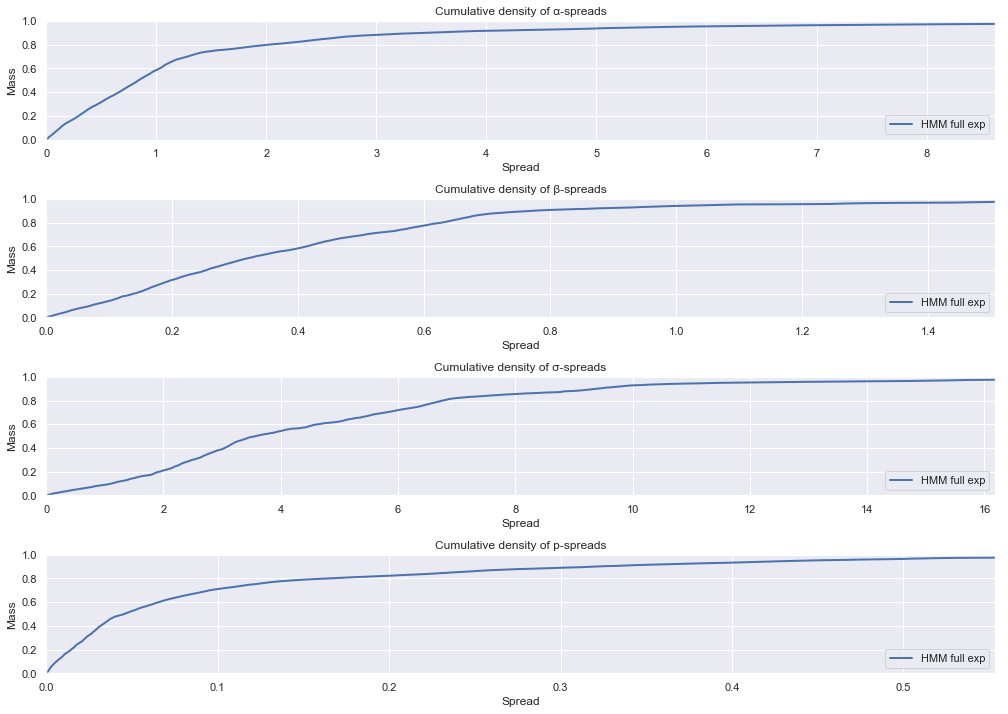

In [652]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['-','-','-','-']#,'--',':','-.']
plot_names = ['Cumulative density of α-spreads','Cumulative density of β-spreads','Cumulative density of σ-spreads','Cumulative density of p-spreads']
data_names = ['alpha_spread','beta_spread','sigma_spread','prob_spread']

fig, axes = plt.subplots(4, 1, figsize=(17,12))


for iAx in range(0,len(axes)):
    for iModel in range(0,len(HMM_model_names)):
        try:
            x = data_out[HMM_model_names[iModel],data_names[iAx]].loc[data_out[HMM_model_names[iModel],'include_model']].abs().sort_values()
            x = x.loc[x.notna()]
            y = np.linspace(0, 1, x.loc[x.notna()].shape[0])
            axes[iAx].plot(x.values, y, linewidth=2, color=colors[iModel], linestyle=linestyles[iModel], label=HMM_model_names[iModel])
            axes[iAx].set_xlim(0, x.quantile(0.975))
            axes[iAx].set_ylim(0, 1)
            axes[iAx].set_title(plot_names[iAx])
            axes[iAx].set_ylabel('Mass')
            axes[iAx].set_xlabel('Spread')
            axes[iAx].legend(loc='lower right')
            
        except:
            pass  
        
plt.subplots_adjust(hspace=0.5)

#### Model fit

To benchmark the regime-switching models, standard CAPM specifications with only one regime are estimated in the same data. The table below reports the frequency of cases where the Markov regime-switching models are preferred over the OLS specifications given various criteria. With eight free parameters instead of two, higher likelihood can easily be achieved. Therefore, more suitable criteria take into account the number of parameters.
Using an Akaike information criterion, the number preferred two-regime specifications drastically decreases. If instead a Bayesian information criterion is used to select the model, only in a small number of cases the Markov models will be preferred.

In [633]:
fit_table = pd.DataFrame(index=['Likelihood','AIC','BIC'], columns=HMM_model_names)

for iModel in HMM_model_names:
    fit_table.loc['Likelihood',iModel] = (data_out[iModel,'likelihood'].loc[data_out[iModel,'include_model']]>data_out[OLS_name[0],'likelihood'].loc[data_out[iModel,'include_model']]).sum() / data_out[iModel,'include_model'].sum()
    fit_table.loc['AIC',iModel] = (data_out[iModel,'aic'].loc[data_out[iModel,'include_model']]<data_out[OLS_name[0],'aic'].loc[data_out[iModel,'include_model']]).sum() / data_out[iModel,'include_model'].sum()
    fit_table.loc['BIC',iModel] = (data_out[iModel,'bic'].loc[data_out[iModel,'include_model']]<data_out[OLS_name[0],'bic'].loc[data_out[iModel,'include_model']]).sum() / data_out[iModel,'include_model'].sum()

fit_table

,HMM full exp
Likelihood,1.0000
AIC,0.9797
BIC,0.8818


If we compare the cross-sectional means of these statistics over time, we recognise that there is time-series variation in how well the models match the data. However, the variation in the fit of the Hidden Markov Models (HMM) closely matches the variation of the OLS specifications. In periods where the HMM models do a relatively poorer job coincide with periods when standard one-regime CAPM regressions also have a decresed ability to explain returns.
Additionally, there are periods in which HMM models do relatively better than the standard CAPM, and periods where the opposite is the case. The HMM models themselves, however, match each other well in terms of fit.

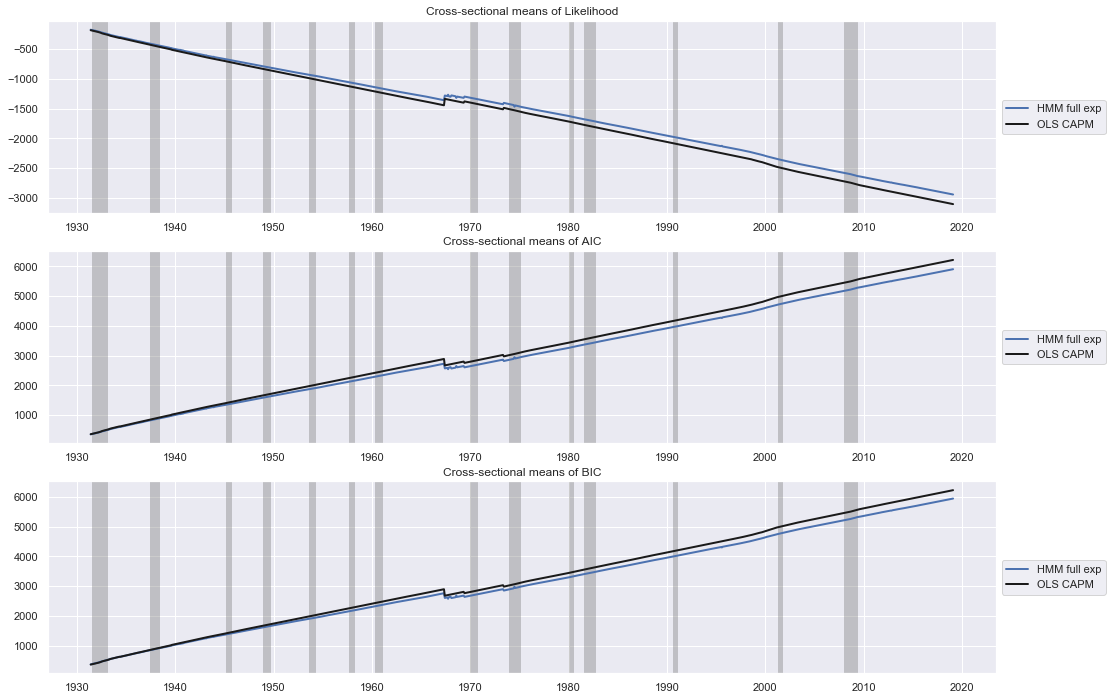

In [636]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
features = ['likelihood','aic','bic']
labels = ['Likelihood','AIC','BIC']

fig, axes = plt.subplots(3,1,figsize=(17,12))

for iAx in range(0,len(axes)):
    for iModel in range(0,len(HMM_model_names)):
        axes[iAx].plot((data_out[HMM_model_names[iModel],features[iAx]]).loc[data_out[HMM_model_names[iModel],'include_model']].groupby('Date').mean(),
             label=HMM_model_names[iModel], linewidth=2, color=colors[iModel])
    axes[iAx].plot((data_out[OLS_name[0],features[iAx]]).groupby('Date').mean(), label='OLS CAPM', linewidth=2, color='k')
    plot.add_recession_bars(axes[iAx], startdate=industries_monthly.index[window_length_monthly])
    axes[iAx].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes[iAx].set_title('Cross-sectional means of '+labels[iAx])

To take into account the suitability of the models we __focus our following analysis on the cases where the respective HMM model achieves a better fit than the one-state CAPM based on the Akaike criterion__.

#### Industry regimes

To describe cross-sectional differences in the characteristics of the regime-Markov-chains, we calculate expected regime durations for each estimated model as the average of both regimes' expected durations:
$$\text{Expected regime duration} = \frac{\frac{1}{1-p_{00}}+\frac{1}{1-p_{11}}}{2}$$
The chart below shows time-series averages by industry for the various model specifications. The black lines signify one standard deviation. An obvious observation from the graph is that restricting the regime-alphas does not impact the ranking of industries as much as restricting sigma does.

In [659]:
for iModel in HMM_model_names:
    data_out[iModel,'likelihood_better'] = data_out[iModel,'likelihood']>data_out[OLS_name[0],'likelihood']
    data_out[iModel,'aic_better'] = data_out[iModel,'aic']<data_out[OLS_name[0],'aic']
    data_out[iModel,'bic_better'] = data_out[iModel,'bic']<data_out[OLS_name[0],'bic']
    data_out[iModel,'beta_significant'] = data_out[iModel,'t_beta'].abs()>1.96
    
data_out['None','post_1960'] = data_out.index.get_level_values(level=1)>dt.datetime(1960,1,1)

In [664]:
for iModel in HMM_model_names:
    data_out[iModel,'incl_crit'] = data_out[iModel,'include_model'] & data_out[iModel,'aic_better'] #& data_out['None','post_1960'] #& data_out[iModel,'beta_significant'] 

IndexError: single positional indexer is out-of-bounds

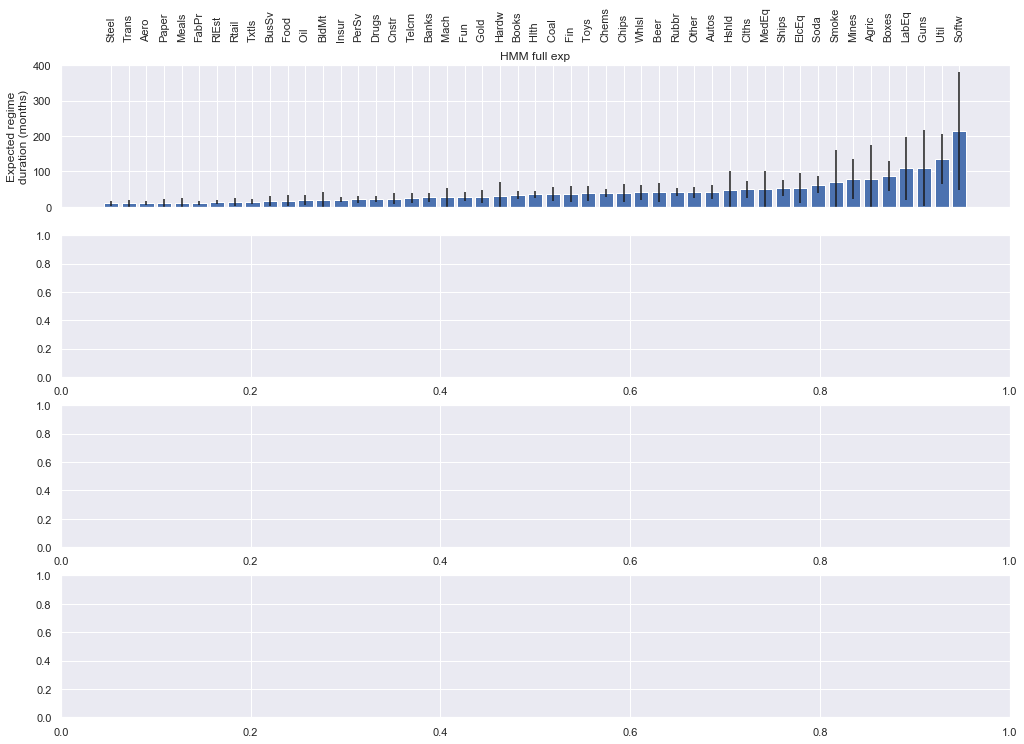

In [665]:
barmeans = pd.DataFrame(index=industries_monthly.columns)
barstd = pd.DataFrame(index=industries_monthly.columns)
for iModel in HMM_model_names:
    barmeans[iModel] = data_out[iModel,'exp_regime_duration'].loc[data_out[iModel,'incl_crit']].groupby('Industry').mean()
    barstd[iModel] = data_out[iModel,'exp_regime_duration'].loc[data_out[iModel,'incl_crit']].groupby('Industry').std()

# sort
barmeans = barmeans.sort_values(barmeans.columns[0], ascending=True)
barstd = barstd.loc[barmeans.index]
    
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(4,1,figsize=(17,12))
for iAx in range(0,4):
    ax = axes[iAx]
    ax.bar(range(0,49), barmeans.iloc[:,iAx], 0.8, yerr=barstd.iloc[:,iAx], color=cycle[iAx])
    ax.set_ylim(0)
    ax.set_ylabel('Expected regime\nduration (months)')
    ax.set_title(barmeans.columns[iAx])
    ax.set_xticks(range(0,49))
    if iAx == 0:
        ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)
        ax.set_xticklabels(barmeans.index, rotation='vertical', y=1.1)
    elif iAx == 3:
        ax.set_xticklabels(barmeans.index, rotation='vertical')
    else:
        ax.set_xticklabels([])

To highlight periods of large regime changes, i.e. periods where the level of regime-innovations is high, let us look at the cross-sectional mean of first differences in regime probabilities. While the financial crisis of 2008 came with a large rise in regime innovations, this phenomenon is not consistently found for other recessions in the sample.

IndexError: list index out of range

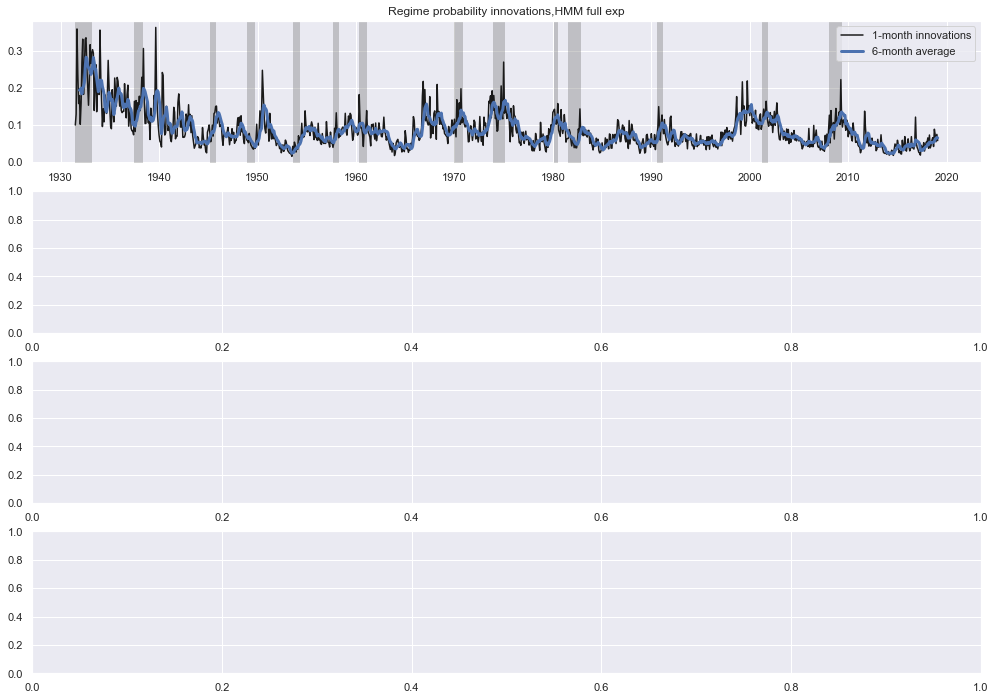

In [666]:
fig, axes = plt.subplots(4, 1, figsize=(17,12))

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for iAx in range(0,4):
    axes[iAx].plot(data_out[HMM_model_names[iAx],'prob_0'].loc[data_out[HMM_model_names[iAx],'incl_crit']].groupby('Industry').diff(1).abs().groupby('Date').mean(), label='1-month innovations', color='k')
    axes[iAx].plot(data_out[HMM_model_names[iAx],'prob_0'].loc[data_out[HMM_model_names[iAx],'incl_crit']].groupby('Industry').diff(1).abs().groupby('Date').mean().rolling(6).mean(), label='6-month average', linewidth=3, color=cycle[iAx])
    #ax = plt.gca()
    plot.add_recession_bars(axes[iAx], startdate=industries_monthly.index[window_length_monthly])
    axes[iAx].legend()
    
    axes[iAx].set_title('Regime probability innovations,' + HMM_model_names[iAx]);
    
plt.subplots_adjust(hspace=0.3)

### Correlation analysis of estimates from various models
To further evaluate the usefulness of the Hidden Markov Models (HMM), we calculate correlations of parameter estimates of such models with their standard CAPM counterparts. In particular, we consider the following:
* __Mean weighted__: The Markov switching model parameter estimates weighted at the mean probabilities of the two regimes over the observation window. If the model parameter is restricted to the same value under both regimes, the value is weighted with probability 1.
* __Last period weighted__: The Markov switching model estimates weighted at the regime-probabilities in the last month in the observation window. If the model parameter is restricted to the same value under both regimes, the value coincides with the 'Last period weighted' value.
* __Expected parameter at t-1__: The Markov switching model estimates weighted at the regime-probabilities in the last month in the observation window, iterated forward by one month through the transition matrix.
* __Same period CAPM__: OLS estimates from CAPM regressions in the same observation window as in the HMM case.
* __Realised CAPM__: OLS estimates from CAPM regressions using 1 month of daily data.

Below therere three comparisons reported in the table:
* __Mean HMM vs. CAPM__: The first sanity check for the HMM models is to compare their estimates with the one-regime case of the standard CAPM. To have a sensible comparison, regime-parameters are weighted at the mean probabilites over the respective sample. Estimates obtained in such a way are considerably correlated to the CAPM equivalents.
* __Last HMM vs. Realised__: Next, we ask if the most recent monthly estimates for each model are correlated with actually realised values. For that purpose, we correlate probability-weighted estimates at the end of each sample with realised CAPM estimates from daily data within the respective month. Correlations in this comparison indicate that HMM models do reasonably well in describing parameters realised within a given month. As a benchmark, the OLS CAPM is additionally correlated to the realised regressions, providing very similar values. Not that this is a contemperaneous relation, not a predictive one.
* __Expected HMM at t-1 vs. Realised (predictive)__: Last, we examine the predictive ability of HMM models with regards to realised volatility in the subsequent month. Instead of using static regime-probabilities, we can iterate one period forward by using the transition matrix. Such predicted regime probabilities are obtained purely from historical data and can therefore serve as a 1-month forecast. Compared to the previous contemperaneous relation, estimates are still similarly strongly correlated.

The numbers in the table are Pearson correlation coefficients calculated over all time periods and assets given the above described sample restrictons.

In [668]:
model_corr_table = pd.DataFrame(index=pd.MultiIndex.from_product([['OLS CAPM'],['']]).append(pd.MultiIndex.from_product([HMM_model_names,['Mean weighted','Last period weighted','Expected parameter at t-1']])),
                                columns=pd.MultiIndex.from_product([['Same period CAPM','Realised CAPM'],['α','β','σ²']]))

model_corr_table.loc[('OLS CAPM',''),('Realised CAPM','α')] = data_out[[['OLS CAPM','alpha'],['Realised CAPM','alpha']]].astype(float).corr().iloc[0,1]
model_corr_table.loc[('OLS CAPM',''),('Realised CAPM','β')] = data_out[[['OLS CAPM','beta'],['Realised CAPM','beta']]].astype(float).corr().iloc[0,1]
model_corr_table.loc[('OLS CAPM',''),('Realised CAPM','σ²')] = data_out[[['OLS CAPM','sigma2'],['Realised CAPM','sigma2']]].astype(float).corr().iloc[0,1]

for iModel in HMM_model_names:
    # Mean HMM vs. CAPM
    try:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','α')] = data_out[[[iModel,'mean_weighted_alpha'],['OLS CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','α')] = data_out[[[iModel,'alpha'],['OLS CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','β')] = data_out[[[iModel,'mean_weighted_beta'],['OLS CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','β')] = data_out[[[iModel,'beta'],['OLS CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','σ²')] = data_out[[[iModel,'mean_weighted_sigma2'],['OLS CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Mean weighted'),('Same period CAPM','σ²')] = data_out[[[iModel,'sigma2'],['OLS CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    
    # Last HMM vs. Realised  
    try:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','α')] = data_out[[[iModel,'weighted_alpha'],['Realised CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','α')] = data_out[[[iModel,'alpha'],['Realised CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','β')] = data_out[[[iModel,'weighted_beta'],['Realised CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','β')] = data_out[[[iModel,'beta'],['Realised CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','σ²')] = data_out[[[iModel,'weighted_sigma2'],['Realised CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Last period weighted'),('Realised CAPM','σ²')] = data_out[[[iModel,'sigma2'],['Realised CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    
    # Expected HMM at t-1 vs. Realised
    try:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','α')] = data_out[[[iModel,'exp_alpha'],['Realised CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','α')] = data_out[[[iModel,'alpha'],['Realised CAPM','alpha']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','β')] = data_out[[[iModel,'exp_beta'],['Realised CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','β')] = data_out[[[iModel,'beta'],['Realised CAPM','beta']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
        
    try:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','σ²')] = data_out[[[iModel,'exp_sigma2'],['Realised CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]
    except:
        model_corr_table.loc[(iModel,'Expected parameter at t-1'),('Realised CAPM','σ²')] = data_out[[[iModel,'sigma2'],['Realised CAPM','sigma2']]].loc[data_out[iModel,'incl_crit']].astype(float).corr().iloc[0,1]

model_corr_table[model_corr_table.isna()] = ''
model_corr_table

Same period CAPM                \
                                                      α      β     σ²   
OLS CAPM                                                                
HMM full exp Mean weighted                       0.3637 0.5914 0.5753   
             Last period weighted                                       
             Expected parameter at t-1                                  

                                       Realised CAPM                
                                                   α      β     σ²  
OLS CAPM                                      0.1395 0.4670 0.4695  
HMM full exp Mean weighted                                          
             Last period weighted             0.0782 0.3742 0.2958  
             Expected parameter at t-1        0.0862 0.3833 0.3192

## Ambiguity measurement

Given the two-regime process, a measure of (expected) ambiguity in such a setting chould take into account:
* The (second-order) probabilities of being in either regime
* The distance between the two regime prior distributions
* The dispersion of parameters under the two regimes

In [294]:
#data_out = data_out.join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([HMM_model_names, ['kolmogorov_smirnov']]), index=data_out.index))

In [669]:
%%time
for iModel in HMM_model_names:
    # second-order probabilities
    data_out[iModel,'prob_distance'] = 1-4*(data_out[iModel,'exp_prob_0']-0.5)**2
    data_out[iModel,'prob_entropy'] = -(data_out[iModel,'exp_prob_0']*np.log2(data_out[iModel,'exp_prob_0']) + data_out[iModel,'exp_prob_1']*np.log2(data_out[iModel,'exp_prob_1'].loc[data_out[iModel,'exp_prob_1']>0]))
    
    # prior dispersion
    try:
        data_out[iModel,'malalanobis_distance'] = ((data_out[iModel,'mu_0']-data_out[iModel,'mu_1'])**2 / ((data_out[iModel,'sigma2_0']+data_out[iModel,'sigma2_1'])/2))**0.5
    except:
        data_out[iModel,'malalanobis_distance'] = ((data_out[iModel,'mu_0']-data_out[iModel,'mu_1'])**2 / ((data_out[iModel,'sigma2']+data_out[iModel,'sigma2'])/2))**0.5
    
    data_out[iModel,'kolmogorov_smirnov'] = np.nan
    for iAsset in industries_monthly.columns:
        for iMonth in data_out.index.get_level_values(1).unique():
            mu_0 = data_out.loc[(iAsset,iMonth),(iModel,'mu_0')]
            mu_1 = data_out.loc[(iAsset,iMonth),(iModel,'mu_1')]
            try:
                sigma2_0 = data_out.loc[(iAsset,iMonth),(iModel,'sigma2_0')]
                sigma2_1 = data_out.loc[(iAsset,iMonth),(iModel,'sigma2_0')]
            except:
                sigma2_0 = data_out.loc[(iAsset,iMonth),(iModel,'sigma2')]
                sigma2_1 = data_out.loc[(iAsset,iMonth),(iModel,'sigma2')]
            
            data_out.loc[(iAsset,iMonth),(iModel,'kolmogorov_smirnov')] = calc.calculate_kolmogorov_smirnov_distance(mu_0, mu_1, sigma2_0, sigma2_1)

    #relative_entropy_monthly = np.log((sigma2_1_monthly**0.5/sigma2_0_monthly**0.5).astype(float)) + \
    #    ((sigma2_0_monthly + ((alpha_0_monthly+beta_0_monthly*expected_market_return)-(alpha_1_monthly+beta_1_monthly*expected_market_return))**2) / \
    #    (2*sigma2_1_monthly)) - 1/2

Wall time: 3min 54s


In [670]:
for iModel in HMM_model_names:
    data_out[iModel,'prob_distance x I'] = data_out[iModel,'prob_distance']*data_out[iModel,'incl_crit']
    data_out[iModel,'prob_entropy x I'] = data_out[iModel,'prob_entropy']*data_out[iModel,'incl_crit']
    data_out[iModel,'malalanobis_distance x I'] = data_out[iModel,'malalanobis_distance']*data_out[iModel,'incl_crit']
    data_out[iModel,'kolmogorov_smirnov x I'] = data_out[iModel,'kolmogorov_smirnov']*data_out[iModel,'incl_crit']
    try:
        data_out[iModel,'alpha_spread x I'] = data_out[iModel,'alpha_spread']*data_out[iModel,'incl_crit']
    except:
        pass
    try:
        data_out[iModel,'beta_spread x I'] = data_out[iModel,'beta_spread']*data_out[iModel,'incl_crit']
    except:
        pass
    try:
        data_out[iModel,'sigma_spread x I'] = data_out[iModel,'sigma_spread']*data_out[iModel,'incl_crit']
    except:
        pass

### Regime-Probabilities
Regarding the probabilities, we can obtain a proxy of ambiguity by considering the dispersion of regime probabilities. If we assume that the agents' perceived ambiguity is related to the uncertainty of being in either of the two regimes, we can construct a measure of ambiguity based on the estimated next-period probabilities of being in either of the states. In this framework, maximum ambiguity is reached when the two states are equally likely (p=0.5). On the other hand there is no ambiguity if all the probability mass is on one state (either p=0 or p=1). Therefore, measures could be:
* The L2-distance to the point of equal probability, scaled between 0 and 1:
$$\mathbb{D}_t\big[r^i_{t+1}\big] = 1-4 \, \big(P_t[S^i_{t+1} = 0]-0.5\big)^2$$
* Shannon entropy:
$$\mathbb{H}_t\big[r^i_{t+1}\big] = -\sum^1_{s_{t+1}=0} P_t[S^i_{t+1} = s_{t+1}] * log_2\big(P_t[S^i_{t+1} = s_{t+1}]\big)$$

Both measures take a value of one if both states are equally likely (maximum ambiguity), and zero if there is no ambiguity about the next period return distribution. Hence they take very similar values.

### Regime-Dispersion
Regarding the distance between the two priors, we can calculate a distance measure between probability distributions, e.g:
* Kolmogorov-Smirnov distance:
$$\mathbb{KS}_t\big[r^i_{t+1}\big] = \sup_{r^i_{t+1}}\Big|\Phi_0(r^i_{t+1})-\Phi_1(r^i_{t+1})\Big| \quad \text{, where $\Phi(.)$ denotes the normal cumulative density function}$$
* Malalanobis distance (Bregman divergence):
$$\mathbb{M}_t\big[r^i_{t+1}\big] = \sqrt{\frac{(\mu^i_0-\mu^i_1)^2}{\frac{(\sigma^i_0)^2+(\sigma^i_1)^2}{2}}}$$

In order to parametrise the probability distributions (i.e. $\mu^i_{s_{t+1}}$ and $\sigma^i_{s_{t+1}}$), the previous estimates are used in combination with the full-sample average of the excess return on the market portfolio (as $\mathbb{E}_t\big[r^M_{t+1}\big]$).

In [222]:
#* Kullback-Leibler divergence (relative entropy):
#$$\mathbb{R}_t\big[r^i_{t+1}\big] = ln\frac{\sigma^i_1}{\sigma^i_0} + \frac{(\sigma^i_0)^2+(\mu^i_0-\mu^i_1)^2}{2(\sigma^i_1)^2}-\frac{1}{2}$$
#Note: Since relative entropy is not bounded from above, it takes some very large values in a few periods where parameters under one regime converge to extreme values. More, relative entropy is probably unsuitable since it is not symetric (it changes if the order of distributions changes).

### Parameter-Dispersion
For parameter dispersion the measures are straight-forward:
$$\mathbb{A}_t\big[r^i_{t+1}\big] = \big|\alpha_0^i-\alpha_1^i\big|$$
$$\mathbb{B}_t\big[r^i_{t+1}\big] = \big|\beta_0^i-\beta_1^i\big|$$
$$\mathbb{S}_t\big[r^i_{t+1}\big] = \big|\sigma_0^i-\sigma_1^i\big|$$

### Summary of measures
To get a feel for the range of values these measures take, below are plot for cross-sectional statistics over time for each of the measures in each of the estimated specifications.

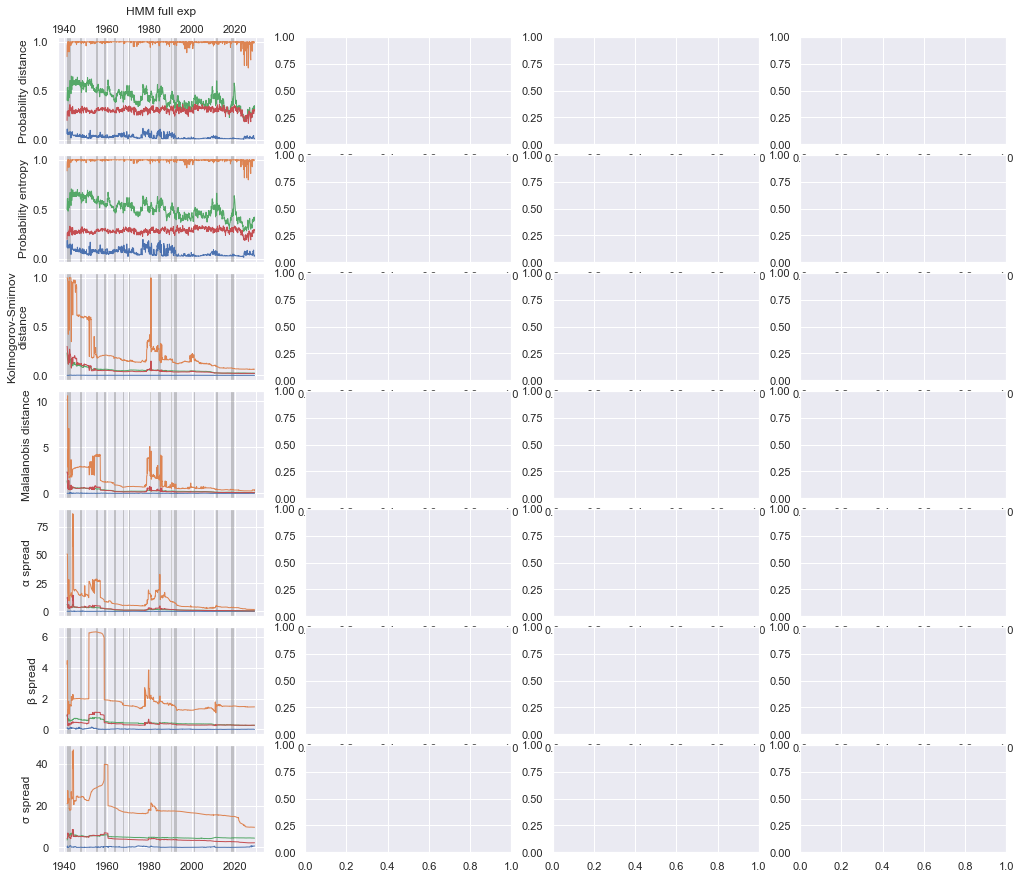

In [671]:
features = ['prob_distance','prob_entropy','kolmogorov_smirnov','malalanobis_distance','alpha_spread','beta_spread','sigma_spread']
titles = ['Probability distance','Probability entropy','Kolmogorov-Smirnov\ndistance','Malalanobis distance','α spread','β spread','σ spread']

fig, axes = plt.subplots(7, 4, figsize=(17,15))

size0 = len(features)
size1 = len(HMM_model_names)

vert = (np.arange(0,size0*size1)-np.floor(np.arange(0,size0*size1)/size0)*size0).astype(int)
horz = (np.floor(np.arange(0,size0*size1)/size0)).astype(int)
    
for (iVert,iHorz) in zip(vert,horz):
    plot.add_recession_bars(axes[iVert,iHorz], startdate=industries_monthly.index[window_length_monthly])
    try:
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].loc[data_out[iModel,'incl_crit']].groupby('Date').min(), linewidth=1, label='Min')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].loc[data_out[iModel,'incl_crit']].groupby('Date').max(), linewidth=1, label='Max')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].loc[data_out[iModel,'incl_crit']].groupby('Date').mean(), linewidth=1, label='Mean')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].loc[data_out[iModel,'incl_crit']].groupby('Date').std(), linewidth=1, label='Std')
        #axes[iVert,iHorz].set_xticks(industries_monthly.index[window_length_monthly:])
    except:
        axes[iVert,iHorz].plot((data_out[('OLS CAPM','alpha')]-data_out[('OLS CAPM','alpha')]).groupby('Date').min(), linewidth=0)
    
    if iVert == 0:
        axes[iVert,iHorz].set_title(HMM_model_names[iHorz], y=1.15)
        #axes[iVert,iHorz].xaxis.set_tick_params(labeltop=True, labelbottom=False)
        axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'], y=1.2)
        if iHorz == 3:
            axes[iVert,iHorz].legend(loc='center left', bbox_to_anchor=(1,0.5))
    elif iVert == 6:
        axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'])
    else:
        axes[iVert,iHorz].set_xticklabels([])
    
    if iHorz == 0:
        axes[iVert,iHorz].set_ylabel(titles[iVert])

plt.subplots_adjust(hspace=0.1)

From these graphs it is visible that the exclusion criterion specified above leads to incomplete series with interruptions. If instead the excluded periods are treated as having zero ambiguity, the measures are better behaved and arguably more complete/representative.

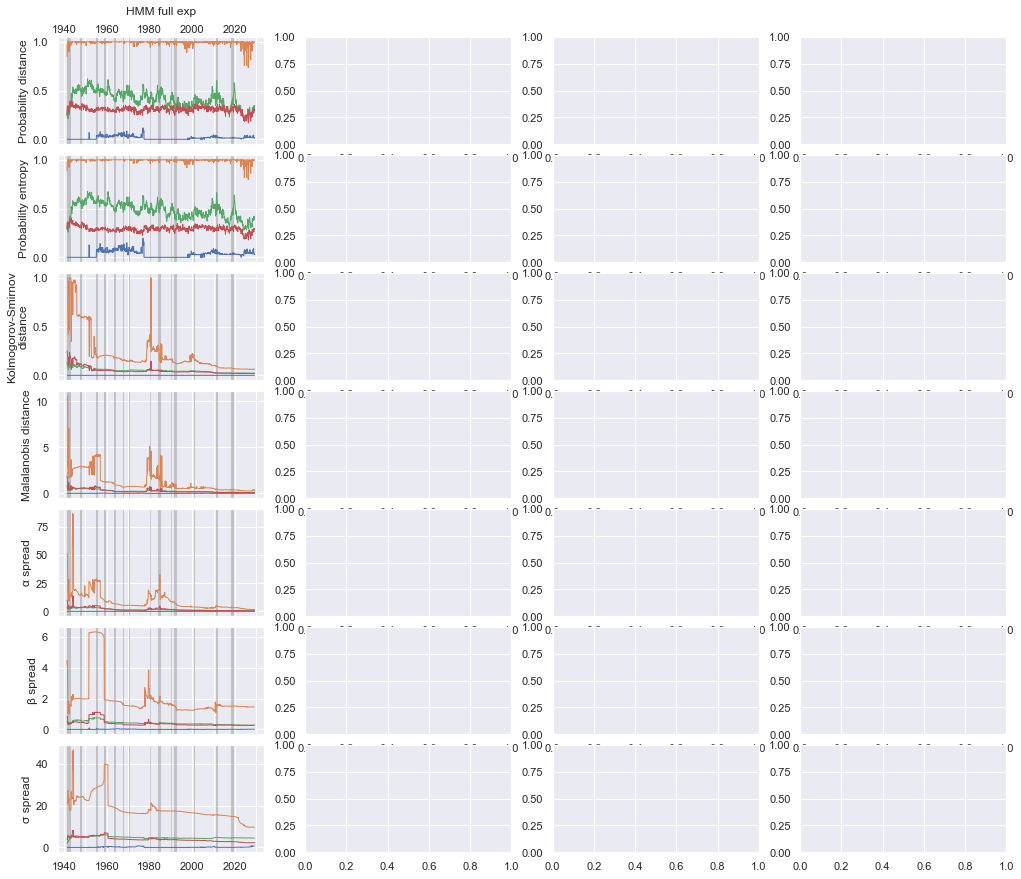

In [672]:
features = ['prob_distance x I','prob_entropy x I','kolmogorov_smirnov x I','malalanobis_distance x I','alpha_spread x I','beta_spread x I','sigma_spread x I']
titles = ['Probability distance','Probability entropy','Kolmogorov-Smirnov\ndistance','Malalanobis distance','α spread','β spread','σ spread']

fig, axes = plt.subplots(7, 4, figsize=(17,15))

size0 = len(features)
size1 = len(HMM_model_names)

vert = (np.arange(0,size0*size1)-np.floor(np.arange(0,size0*size1)/size0)*size0).astype(int)
horz = (np.floor(np.arange(0,size0*size1)/size0)).astype(int)
    
for (iVert,iHorz) in zip(vert,horz):
    plot.add_recession_bars(axes[iVert,iHorz], startdate=industries_monthly.index[window_length_monthly])
    try:
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].groupby('Date').min(), linewidth=1, label='Min')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].groupby('Date').max(), linewidth=1, label='Max')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].groupby('Date').mean(), linewidth=1, label='Mean')
        axes[iVert,iHorz].plot(data_out[HMM_model_names[iHorz],features[iVert]].groupby('Date').std(), linewidth=1, label='Std')
        #axes[iVert,iHorz].set_xticks(industries_monthly.index[window_length_monthly:])
    except:
        axes[iVert,iHorz].plot((data_out[('OLS CAPM','alpha')]-data_out[('OLS CAPM','alpha')]).groupby('Date').min(), linewidth=0)
    
    if iVert == 0:
        axes[iVert,iHorz].set_title(HMM_model_names[iHorz], y=1.15)
        #axes[iVert,iHorz].xaxis.set_tick_params(labeltop=True, labelbottom=False)
        axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'], y=1.2)
        if iHorz == 3:
            axes[iVert,iHorz].legend(loc='center left', bbox_to_anchor=(1,0.5))
    elif iVert == 6:
        axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'])
    else:
        axes[iVert,iHorz].set_xticklabels([])
    
    if iHorz == 0:
        axes[iVert,iHorz].set_ylabel(titles[iVert])

plt.subplots_adjust(hspace=0.1)

### Measure Comparison

#### Summary Statistics

The following table is calculated using all observations across assets and time periods.

In [673]:
data_corr = pd.DataFrame(index=data_out.index, columns=pd.MultiIndex.from_product([[],[]]))

for iModel in HMM_model_names:
    # second-order probabilities
    data_corr[iModel,'D'] = data_out[iModel,'prob_distance'].loc[data_out[iModel,'incl_crit']]
    data_corr[iModel,'H'] = data_out[iModel,'prob_entropy'].loc[data_out[iModel,'incl_crit']]
    # regime dispersion measures
    data_corr[iModel,'KS'] = data_out[iModel,'kolmogorov_smirnov'].loc[data_out[iModel,'incl_crit']]
    data_corr[iModel,'M'] = data_out[iModel,'malalanobis_distance'].loc[data_out[iModel,'incl_crit']]

In [674]:
data_corr.describe()

HMM full exp                                 
                 D          H         KS          M
count   46724.0000 46724.0000 46724.0000 46724.0000
mean        0.4212     0.4945     0.0490     0.2601
std         0.3128     0.2955     0.0619     0.3396
min         0.0056     0.0154     0.0000     0.0000
25%         0.1417     0.2273     0.0113     0.0753
50%         0.3239     0.4327     0.0351     0.1736
75%         0.6828     0.7572     0.0672     0.3310
max         1.0000     1.0000     1.0000    10.5851

Where:
* __D__: L2-distance
* __H__: Shannon entropy
* __KS__: Kolmogorov-Smirnov distance
* __M__: Malalanobis distance

In [283]:
#Turning to summary statistics, we can confirm that relative entropy is in undesirable candidate for a measure. Another thing to point out here is that, while the variation in KS has a similar magnitude as D and H, the measure M varies a lot more and therefore dominates interactions.

#### Correlations

Given the similarity of some of the measures, we next look at correlations across measures of regime-probability dispersion, regime disperion, and interactions. Correlations are calculated using the full time-series and the full-cross-section.

In [675]:
data_corr.corr().where(np.triu(np.ones(data_corr.shape[1])).astype(bool)).replace(np.nan,'')

HMM full exp                     
                           D      H     KS      M
HMM full exp D        1.0000 0.9959 0.1327 0.1309
             H               1.0000 0.1342 0.1312
             KS                     1.0000 0.6753
             M                             1.0000

Where:
* __D__: L2-distance
* __H__: Shannon entropy
* __KS__: Kolmogorov-Smirnov distance
* __M__: Malalanobis distance

With a correlation above 0.99, the choice between D and H is a pure matter of preference. 
The choice between KS and M is more complex as both are mildly to highly positively correlated depending on the model specification. M appears to add more independent information to the measures of probability dispersion as correlations are smaller (more negative).

### Interactions

To take into account multiple dimensions of ambiguity (probabilities, distributions and parameters), we can create combined measures by interaction. While distributions are directly linked to the parameters, we are mainly interested in the combined effects of D and these measures. Therefore, we interact D with KS, M, A, B, and S. Summary statistics and correaltions are reported below.

In [676]:
data_inter = pd.DataFrame(index=data_out.index, columns=pd.MultiIndex.from_product([[],[]]))

for iModel in HMM_model_names:
    data_inter[iModel,'D x KS'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'kolmogorov_smirnov']) [data_out[iModel,'incl_crit']]
    data_inter[iModel,'D x M'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'malalanobis_distance']) [data_out[iModel,'incl_crit']]
    #data_inter[iModel,'D x E'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'exp_mean']) [data_out[iModel,'include_model']]
    #data_inter[iModel,'D x V'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'exp_var']) [data_out[iModel,'include_model']]
    try:
        data_inter[iModel,'D x A'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'alpha_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass
    try:
        data_inter[iModel,'D x B'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'beta_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass
    try:
        data_inter[iModel,'D x S'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'sigma_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass
    
if 1 == 0:
#for iModel in HMM_model_names:
    data_inter[iModel,'H x KS'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'kolmogorov_smirnov']) [data_out[iModel,'incl_crit']]
    data_inter[iModel,'H x M'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'malalanobis_distance']) [data_out[iModel,'incl_crit']]
    data_inter[iModel,'D x E'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'exp_mean']) [data_out[iModel,'incl_crit']]
    data_inter[iModel,'D x V'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'exp_var']) [data_out[iModel,'incl_crit']]
    try:
        data_inter[iModel,'H x A'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'alpha_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass
    try:
        data_inter[iModel,'H x B'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'beta_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass
    try:
        data_inter[iModel,'H x S'] = (data_out[iModel,'prob_entropy'] * data_out[iModel,'sigma_spread']) [data_out[iModel,'incl_crit']]
    except:
        pass

In [677]:
data_inter.describe()

HMM full exp                                            
            D x KS      D x M      D x A      D x B      D x S
count   46724.0000 46724.0000 46724.0000 46724.0000 46724.0000
mean        0.0232     0.1235     0.6585     0.1815     1.6878
std         0.0382     0.1821     1.3179     0.2479     1.8951
min         0.0000     0.0000     0.0000     0.0000     0.0001
25%         0.0022     0.0147     0.0787     0.0290     0.5533
50%         0.0088     0.0471     0.2315     0.0900     1.0886
75%         0.0316     0.1550     0.6514     0.2508     2.1001
max         0.9322     2.3366    26.7916     2.9809    26.3113

In [678]:
data_inter.corr().where(np.triu(np.ones(data_inter.shape[1])).astype(bool)).replace(np.nan,'')

HMM full exp                            
                          D x KS  D x M  D x A  D x B  D x S
HMM full exp D x KS       1.0000 0.7116 0.4380 0.3357 0.2029
             D x M               1.0000 0.7618 0.5566 0.2671
             D x A                      1.0000 0.6044 0.5889
             D x B                             1.0000 0.4741
             D x S                                    1.0000

Where:
* __D__: L2-distance
* __KS__: Kolmogorov-Smirnov distance
* __M__: Malalanobis distance
* __A__: $\alpha$-spread
* __B__: $\beta$-spread
* __S__: $\sigma$-spread

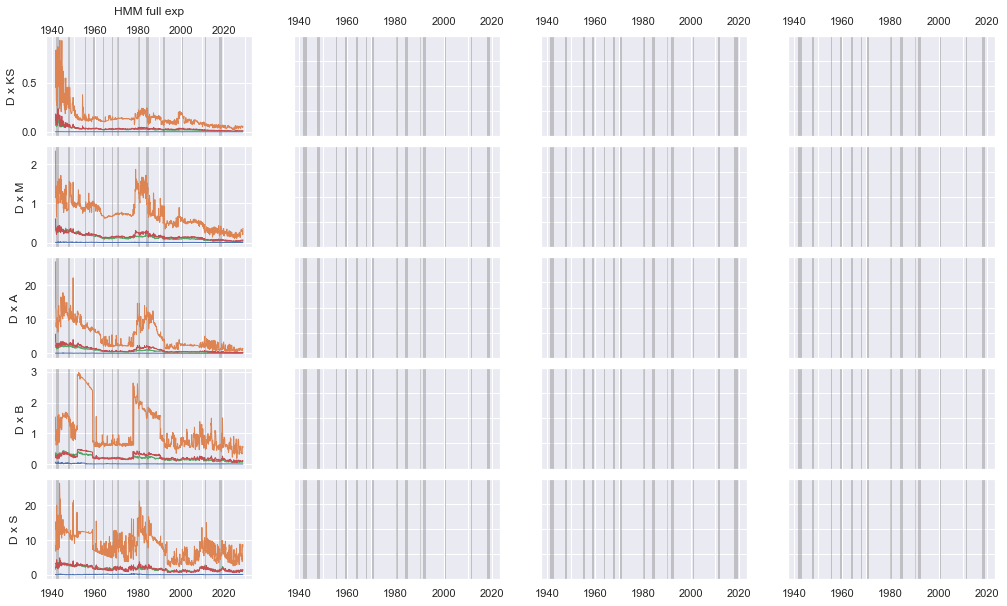

In [679]:
features = ['D x KS','D x M','D x A','D x B','D x S']
titles = features#['Probability distance','Probability entropy','Kolmogorov-Smirnov\ndistance','Malalanobis distance']

fig, axes = plt.subplots(5, 4, figsize=(17,10))

vert = (np.arange(0,4*5)-np.floor(np.arange(0,4*5)/5)*5).astype(int)
horz = (np.floor(np.arange(0,4*5)/5)).astype(int)
    
for (iVert,iHorz) in zip(vert,horz):
    plot.add_recession_bars(axes[iVert,iHorz], startdate=industries_monthly.index[window_length_monthly])
    try:
        axes[iVert,iHorz].plot(data_inter[HMM_model_names[iHorz],features[iVert]].groupby('Date').min(), linewidth=1, label='Min')
        axes[iVert,iHorz].plot(data_inter[HMM_model_names[iHorz],features[iVert]].groupby('Date').max(), linewidth=1, label='Max')
        axes[iVert,iHorz].plot(data_inter[HMM_model_names[iHorz],features[iVert]].groupby('Date').mean(), linewidth=1, label='Mean')
        axes[iVert,iHorz].plot(data_inter[HMM_model_names[iHorz],features[iVert]].groupby('Date').std(), linewidth=1, label='Std')
        #axes[iVert,iHorz].set_xticks(industries_monthly.index[window_length_monthly:])
    
        if iVert == 0:
            axes[iVert,iHorz].set_title(HMM_model_names[iHorz], y=1.15)
            #axes[iVert,iHorz].xaxis.set_tick_params(labeltop=True, labelbottom=False)
            axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'], y=1.2)
            if iHorz ==3:
                axes[iVert,iHorz].legend(loc='center left', bbox_to_anchor=(1,0.5))
        elif iVert == 4:
            axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'])
        else:
            axes[iVert,iHorz].set_xticklabels([])
    
        if iHorz == 0:
            axes[iVert,iHorz].set_ylabel(titles[iVert])
    except:
        if iVert == 0:
            axes[iVert,iHorz].xaxis.set_tick_params(labeltop=True, labelbottom=False)
            axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'])
        elif iVert == 4:
            axes[iVert,iHorz].set_xticklabels(['','1940','','1960','','1980','','2000','','2020'])
        else:
            axes[iVert,iHorz].set_xticklabels([])
            
        axes[iVert,iHorz].set_yticklabels([])

plt.subplots_adjust(hspace=0.1)

#### What Industries are ambiguous?
To investigate which industries are ambiguous on average, we calculate time-series means of each measure of ambiguity under each model. The heatmap below shows cross-sectional ranks of such time-series averages. No clear pattern is visible, due to the low correlations between the various measures. Industries that are relatively ambiguous under some measures have very different ambiguity ranks under other measures, even within the same models. This could be due to measurement problems or just, that time-series variation in the measures is so strong that ranks frequently change and averages are not informative.

IndexError: list index out of range

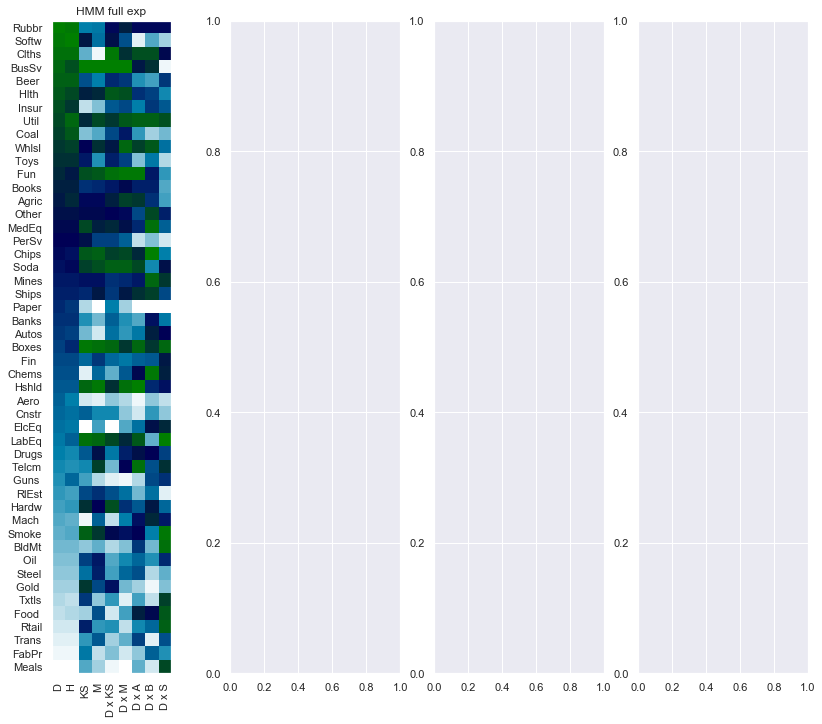

In [680]:
data_means = data_corr.merge(data_inter, left_index=True, right_on=['Industry','Date']).rename_axis(('Industry','Date')).groupby('Industry').mean()

fig, axes = plt.subplots(1, 4, figsize=(14,12))

for iAx in range(0,4):
    im = axes[iAx].imshow(data_means[HMM_model_names[iAx]].sort_values('D').rank(axis=0), cmap='ocean')

    axes[iAx].set_xticks(np.arange(len(data_means[HMM_model_names[iAx]].columns)))
    axes[iAx].set_yticks(np.arange(len(data_means[HMM_model_names[iAx]].index)))

    # ... and label them with the respective list entries
    axes[iAx].set_xticklabels(data_means[HMM_model_names[iAx]].columns, rotation = 'vertical')
    axes[iAx].set_yticklabels(data_means[HMM_model_names[iAx]].sort_values('D').index)
    axes[iAx].grid(False)
    axes[iAx].set_title(HMM_model_names[iAx])
    if iAx == 3:
        cbar = axes[iAx].figure.colorbar(im)
        cbar.ax.set_ylabel('Rank of mean ambiguity measure (descending)', rotation=90)

## Analysis

In [682]:
data_reg = pd.DataFrame(index=data_out.index)

# Constant
data_reg['Ones','constant'] = 1

# Add returns
data_reg = data_reg.merge(industries_monthly.T.stack(dropna=False).rename(('Returns','R_t')).to_frame(), left_index=True, right_on=['Industry','Date']).rename_axis(('Industry','Date'))

# Add following period returns
data_reg[('Returns','R_t+1')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-1)
data_reg[('Returns','R_t+2')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-2)
data_reg[('Returns','R_t+3')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-3)
data_reg[('Returns','R_t+4')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-4)
data_reg[('Returns','R_t+5')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-5)
data_reg[('Returns','R_t+6')] = data_reg[('Returns','R_t')].groupby('Industry').shift(-6)

# Add cumulative returns
#data_reg[('Returns','R_t+1-t+2')] = ((data_reg[('Returns','R_t+1')]/100+1) * (data_reg[('Returns','R_t+2')]/100+1) -1)*100
#data_reg[('Returns','R_t+1-t+3')] = ((data_reg[('Returns','R_t+1-t+2')]/100+1) * (data_reg[('Returns','R_t+3')]/100+1) -1)*100
#data_reg[('Returns','R_t+1-t+4')] = ((data_reg[('Returns','R_t+1-t+3')]/100+1) * (data_reg[('Returns','R_t+4')]/100+1) -1)*100
#data_reg[('Returns','R_t+1-t+5')] = ((data_reg[('Returns','R_t+1-t+4')]/100+1) * (data_reg[('Returns','R_t+5')]/100+1) -1)*100
#data_reg[('Returns','R_t+1-t+6')] = ((data_reg[('Returns','R_t+1-t+5')]/100+1) * (data_reg[('Returns','R_t+6')]/100+1) -1)*100

# Drop contemperaneous return
#data_reg = data_reg.drop(('Returns','R_t'), axis=1)

# Add ambiguity data
data_reg = data_reg.merge(data_corr, left_index=True, right_on=['Industry','Date']).merge(data_inter, left_index=True, right_on=['Industry','Date']).rename_axis(('Industry','Date'))

# Reindex
data_reg.columns = pd.MultiIndex.from_tuples(data_reg.columns)

for iModel in HMM_model_names:
    # Controls
    for iFeat in ['exp_mean','exp_var','exp_alpha','exp_beta','exp_sigma2','aic']:
        try:
            data_reg[iModel,iFeat] = data_out[iModel,iFeat].loc[data_out[iModel,'incl_crit']]
        except:
            pass
    
    # Interactions
    data_reg[iModel,'D x E'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'exp_mean']) [data_out[iModel,'incl_crit']]
    data_reg[iModel,'D x V'] = (data_out[iModel,'prob_distance'] * data_out[iModel,'exp_var']) [data_out[iModel,'incl_crit']]

# Realised CAPM
for iFeat in ['alpha','beta','sigma2']:
    data_reg['Realised CAPM',iFeat] = data_out['Realised CAPM',iFeat]
    data_reg['OLS CAPM',iFeat] = data_out['OLS CAPM',iFeat]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Pooled Regressions

To establish whether the ambiguity measure predicts returns on the subsequent period, we run pooled regressions of the following form:
$$ r_{t+1}^i = \theta_0 + \theta_1 \, \text{Expected Ambiguity}_t\big[r^i_{t+1}\big] + \gamma \, X^i_t + \varepsilon_{t+1}^i $$

$\text{Expected Ambiguity}_t\big[r^i_{t+1}\big]$ is one of the ambiguity measures defined in the above section and is the independent variable of interest.

$X^i_t$ is a set of conditioning variables. After considering univariate regressions of returns on ambiguity as depicted in the scatter plot below, we include the expected first two moments of the mixed prior distribution to contrast the effect of ambiguity with that of risk. These expected moments incorporate the expected parameters obtained from the Markov chain of regime probabilities. In another specification we can also directly include the expected parameters $\alpha$, $\beta$ and $\sigma^2$. Lastly, we condition on OLS CAPM regression estimates to account for standard CAPM risk metrics.

To disentangle the cross-sectional effects from the time-series, we additionally allow for time-fixed-effects $\lambda_t$ and industry-fixed-effects $\alpha^i$:
$$ r_{t+1}^i = \theta_0 + \theta_1 \, \text{Expected Ambiguity}_t\big[r^i_{t+1}\big] + \gamma \, X^i_t + \alpha^i + \lambda_t +\varepsilon_{t+1}^i $$

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


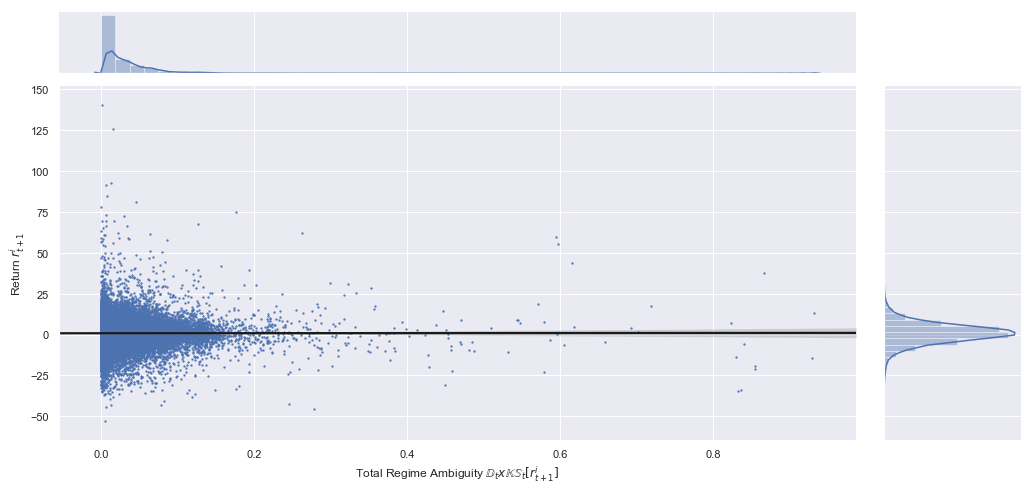

In [683]:
joint = sns.jointplot(x=('HMM full exp','D x KS'), y=('Returns','R_t+1'), data=data_reg, dropna=True, kind="reg", joint_kws={'color':'b', 'scatter_kws':{'s': 2},'line_kws':{'color':'k'}})
joint.fig.set_figwidth(16)
joint.fig.set_figheight(7)

plt.xlabel("Total Regime Ambiguity $\mathbb{D}_t x \mathbb{KS}_t[r^i_{t+1}]$")
plt.ylabel("Return $r^i_{t+1}$");

Below are parameter estimates and t-statistics (with Driscoll-Kraay standard errors) from a various regression specifications.

In [200]:
labels = data_reg['Returns'].columns

feat_names = {'c': 'constant',
          'D': '$\mathbb{D}_t[r^i_{t+1}]$',
          'KS': '$\mathbb{KS}_t[r^i_{t+1}]$',
          'M': '$\mathbb{M}_t[r^i_{t+1}]$',
          'D x KS': '$\mathbb{D}_t\times\mathbb{KS}_t[r^i_{t+1}]$',
          'D x M': '$\mathbb{D}_t\times\mathbb{M}_t[r^i_{t+1}]$',
          'D x A': '$\mathbb{D}_t\times\mathbb{A}_t[r^i_{t+1}]$',
          'D x B': '$\mathbb{D}_t\times\mathbb{B}_t[r^i_{t+1}]$',
          'D x S': '$\mathbb{D}_t\times\mathbb{S}_t[r^i_{t+1}]$',
          'E': '$\mathbb{E}_t[r^i_{t+1}]$',
          'V': '$\mathbb{V}_t[r^i_{t+1}]$',
          'ea': '$\mathbb{E}_t[α^i_{t+1}]$',
          'eb': '$\mathbb{E}_t[β^i_{t+1}]$',
          'es': '$\mathbb{E}_t[(σ^2)^i_{t+1}]$',
          'ra': 'realised $α_t$',
          'rb': 'realised $β_t$',
          'rs': 'realised $σ^2_t$',
          'oa': 'OLS $α_t$',
          'ob': 'OLS $β_t$',
          'os': 'OLS $σ^2_t$',
         }

independents = ['D','KS','M','D x KS','D x M','D x B']#,'D x A','D x S']

controls = [[],
            ['E','V'],
            ['ea','eb','es'],
            ['ra','rb','rs'],
            ['oa','ob','os']]

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([list(feat_names.values()),['est.','s.e.','t-stat']]).append(pd.MultiIndex.from_product([['fixed effect'],['industry','time']])).append(pd.MultiIndex.from_product([['stats'],['R²','N']])),\
                        columns=pd.MultiIndex.from_product([HMM_model_names,labels,['('+str(x)+')' for x in np.arange(1,4*len(independents)*len(controls)+1)]]))

In [121]:
feat_names['None']
#feat_names[iInd]
#[feat_names[iInd]]
#[feat_names['c']]+[feat_names[iInd]]+[feat_names[x] for x in iCont]
#reg_table.loc[([feat_names['c']]+[feat_names[iInd]]+[feat_names[x] for x in iCont],'est.'),(iModel,iLabel,'('+str(count)+')')]

In [201]:
%%time
count_all = 0
for iModel in HMM_model_names:
    features = {'c': ('Ones','constant'),
                'D': (iModel,'D'),
                'KS': (iModel,'KS'),
                'M': (iModel,'M'),
                'D x KS': (iModel,'D x KS'),
                'D x M': (iModel,'D x M'),
                'D x A': (iModel,'D x A'),
                'D x B': (iModel,'D x B'),
                'D x S': (iModel,'D x S'),
                'E': (iModel,'exp_mean'),
                'V': (iModel,'exp_var'),
                'ea': (iModel,'exp_alpha'),
                'eb': (iModel,'exp_beta'),
                'es': (iModel,'exp_sigma2'),
                'ra': ('Realised CAPM','alpha'),
                'rb': ('Realised CAPM','beta'),
                'rs': ('Realised CAPM','sigma2'),
                'oa': ('OLS CAPM','alpha'),
                'ob': ('OLS CAPM','beta'),
                'os': ('OLS CAPM','sigma2'),
               }
    for iLabel in labels:
        count = 0
        for iInd in independents:
      #      if iInd not in data_reg.columns:
      #          iInd = None
            for iCont in controls:
                iIncl = [features[x] in data_reg.columns for x in iCont]
                iCont = [cont for (cont, incl) in zip(iCont, iIncl) if incl]
                for iEnt in [False, True]:
                    for iTime in [False, True]:
                        count += 1
                        count_all += 1
                        # run regression
                        reg = lm.PanelOLS(data_reg[('Returns',iLabel)], data_reg[[features['c']]+[features[iInd]]+[features[x] for x in iCont]], entity_effects=iEnt, time_effects=iTime).fit(cov_type='kernel')
                        
                        # store
                        reg_table.loc[([feat_names['c']]+[feat_names[iInd]]+[feat_names[x] for x in iCont],'est.'),(iModel,iLabel,'('+str(count)+')')] = reg.params.values
                        reg_table.loc[([feat_names['c']]+[feat_names[iInd]]+[feat_names[x] for x in iCont],'s.e.'),(iModel,iLabel,'('+str(count)+')')] = reg.std_errors.values
                        reg_table.loc[([feat_names['c']]+[feat_names[iInd]]+[feat_names[x] for x in iCont],'t-stat'),(iModel,iLabel,'('+str(count)+')')] = reg.tstats.values
                        reg_table.loc[('fixed effect','industry'),(iModel,iLabel,'('+str(count)+')')] = iEnt
                        reg_table.loc[('fixed effect','time'),(iModel,iLabel,'('+str(count)+')')] = iTime
                        reg_table.loc[('stats','R²'),(iModel,iLabel,'('+str(count)+')')] = reg.rsquared
                        reg_table.loc[('stats','N'),(iModel,iLabel,'('+str(count)+')')] = reg.nobs
                        
                        if count_all%(4*len(independents)*len(controls)) == 0:
                            print('finished', count_all, 'out of', len(reg_table.columns))

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


finished 120 out of 3360
finished 240 out of 3360
finished 360 out of 3360
finished 480 out of 3360
finished 600 out of 3360
finished 720 out of 3360
finished 840 out of 3360
finished 960 out of 3360
finished 1080 out of 3360
finished 1200 out of 3360
finished 1320 out of 3360
finished 1440 out of 3360
finished 1560 out of 3360
finished 1680 out of 3360
finished 1800 out of 3360
finished 1920 out of 3360
finished 2040 out of 3360
finished 2160 out of 3360
finished 2280 out of 3360
finished 2400 out of 3360
finished 2520 out of 3360
finished 2640 out of 3360
finished 2760 out of 3360
finished 2880 out of 3360
finished 3000 out of 3360
finished 3120 out of 3360
finished 3240 out of 3360
finished 3360 out of 3360
Wall time: 15min 15s


In [184]:
#reg_table.T.loc[reg_table.T[('$\mathbb{E}_t[α^i_{t+1}]$','t-stat')].abs()>1.96]['$\mathbb{E}_t[α^i_{t+1}]$']

In [409]:
#reg1 = lm.PanelOLS(data_reg[('Returns','R_t+1')],sm.add_constant(data_out[('HMM full','prob_distance')]), entity_effects=False, time_effects=False).fit(cov_type='kernel')
#reg1#.summary

In [220]:
reg_table.to_csv('regs.csv')

In [569]:
feat_names = {'c': 'constant',
          'D': '$\mathbb{D}_t[r^i_{t+1}]$',
          'D x KS': '$\mathbb{D}_t\times\mathbb{KS}_t[r^i_{t+1}]$',
          'D x B': '$\mathbb{D}_t\times\mathbb{B}_t[r^i_{t+1}]$',
          'E': '$\mathbb{E}_t[r^i_{t+1}]$',
          'V': '$\mathbb{V}_t[r^i_{t+1}]$',
          'ea': '$\mathbb{E}_t[α^i_{t+1}]$',
          'eb': '$\mathbb{E}_t[β^i_{t+1}]$',
          'es': '$\mathbb{E}_t[(σ^2)^i_{t+1}]$',
          'ra': 'realised $α_t$',
          'rb': 'realised $β_t$',
          'rs': 'realised $σ^2_t$',
          'oa': 'OLS $α_t$',
          'ob': 'OLS $β_t$',
          'os': 'OLS $σ^2_t$',
         }

regs_out = pd.DataFrame(index=pd.MultiIndex.from_product([list(feat_names.values()),['est.','t-stat']]).append(pd.MultiIndex.from_product([['fixed effect'],['industry','time']])).append(pd.MultiIndex.from_product([['stats'],['R²','N']])),\
                       )

In [570]:
cols = [('HMM full','R_t+1','('+str(x)+')') for x in [1,5,9,13,17,4,61,65,69,73,77,64,101,105,109,113,117,104]]

regs_out = regs_out.merge(reg_table[cols].rename_axis(('coeff','attrib')), how='inner', left_index=True, right_on=['coeff','attrib'])
regs_out.columns = pd.MultiIndex.from_product([['D','D x KS','D x B'],['('+str(x)+')' for x in np.arange(1,7)]])
regs_out[regs_out.isna()] = ''
regs_out[regs_out == False] = ''

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


In [571]:
regs_out

D                  \
                                                          (1)     (2)     (3)   
constant                                     est.      0.8914  0.8499  0.8278   
                                             t-stat    3.1628  3.1089  2.8502   
$\mathbb{D}_t[r^i_{t+1}]$                    est.     -0.0127 -0.0046  0.0082   
                                             t-stat   -0.0586 -0.0216  0.0391   
$\mathbb{D}_t\times\mathbb{KS}_t[r^i_{t+1}]$ est.                               
                                             t-stat                             
$\mathbb{D}_t\times\mathbb{B}_t[r^i_{t+1}]$  est.                               
                                             t-stat                             
$\mathbb{E}_t[r^i_{t+1}]$                    est.             -0.0197           
                                             t-stat           -0.1849           
$\mathbb{V}_t[r^i_{t+1}]$                    est.              0.0022           
                                             t-stat            0.6988           
$\mathbb{E}_t[α^i_{t+1}]$                    est.                     -0.0302   
                                             t-stat                   -0.2758   
$\mathbb{E}_t[β^i_{t+1}]$                    est.                     -0.0179   
                                             t-stat                   -0.0724   
$\mathbb{E}_t[(σ^2)^i_{t+1}]$                est.                      0.0037   
                                             t-stat                    0.9332   
realised $α_t$                               est.                               
                                             t-stat                             
realised $β_t$                               est.                               
                                             t-stat                             
realised $σ^2_t$                             est.                               
                                             t-stat                             
OLS $α_t$                                    est.                               
                                             t-stat                             
OLS $β_t$                                    est.                               
                                             t-stat                             
OLS $σ^2_t$                                  est.                               
                                             t-stat                             
fixed effect                                 industry                           
                                             time                               
stats                                        R²        0.0000  0.0002  0.0004   
                                             N          16303   16303   16303   

                                                                               \
                                                          (4)     (5)     (6)   
constant                                     est.      0.6399  0.9715  0.8384   
                                             t-stat    2.3831  2.3981 11.7625   
$\mathbb{D}_t[r^i_{t+1}]$                    est.     -0.0111  0.0287  0.0890   
                                             t-stat   -0.0513  0.1369  0.6517   
$\mathbb{D}_t\times\mathbb{KS}_t[r^i_{t+1}]$ est.                               
                                             t-stat                             
$\mathbb{D}_t\times\mathbb{B}_t[r^i_{t+1}]$  est.                               
                                             t-stat                             
$\mathbb{E}_t[r^i_{t+1}]$                    est.                               
                                             t-stat                             
$\mathbb{V}_t[r^i_{t+1}]$                    est.                               
                                             t-stat                             
$\mathbb{

Unfortunately, the regressions (among other specifications) are insignificant. To understand the reasons behind this change with regards to earlier versions, there are several potential contributors:
* Change of the numerical optimiser with starting values
* Stricter exclusion criteria for industry-period pairs with undesired behavior
* The use of more conservative standard errors
* Direct use of the data without cross-sectional standardisation

### Portfolio Sorts

#### Functions

In [527]:
def sort_portfolios(returns, ranking_variable, n_portfolios, lags=1, return_assets=False):
    # align periods
    sorting_variable = ranking_variable.shift(lags)
    
    # set up parameters
    [t,n] = returns.shape
    include = returns.notna() & sorting_variable.notna()
    n_period = include.sum(axis=1)

    # sort assets
    returns[~include] = np.nan
    sorting_variable[~include] = np.nan
    cutoff_ranks = np.dot(n_period.values.reshape(t,1)/n_portfolios,np.arange(n_portfolios+1).reshape(1,n_portfolios+1)).round()
    asset_ranks = sorting_variable.rank(axis=1)
    
    # set up output frames
    portfolio_returns = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_assets = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_mapping = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    # calculate outputs
    for i_portfolio in range(0,n_portfolios):
        lower = cutoff_ranks[:,i_portfolio].reshape(t,1).repeat(n, axis=1)
        upper = cutoff_ranks[:,i_portfolio+1].reshape(t,1).repeat(n, axis=1)
        portfolio_returns[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].mean(axis=1)
        portfolio_assets[i_portfolio+1] = ((asset_ranks>lower) & (asset_ranks<=upper)).sum(axis=1)
        portfolio_mapping[(asset_ranks>lower) & (asset_ranks<=upper)] = i_portfolio
    
    # outputs
    if return_assets == False:
        return portfolio_returns
    else:
        return portfolio_returns, portfolio_assets, portfolio_mapping

In [132]:
def double_sort_portfolios(returns, ranking_variable_1, ranking_variable_2, n_portfolios_1, n_portfolios_2, lags_1=1, lags_2=1, return_assets=False):
    # identify missing values
    exclude = returns.isna() | ranking_variable_1.shift(lags_1).isna() | ranking_variable_2.shift(lags_2).isna()
    returns[exclude] = np.nan
    
    # first sort
    portfolio_mapping_1 = sort_portfolios(returns, ranking_variable_1, n_portfolios_1, lags_1, return_assets=True)[2]
    
    # second sorts
    portfolio_mapping_2 = pd.DataFrame(0, index=portfolio_mapping_1.index, columns=portfolio_mapping_1.columns)
    for i_portfolio_2 in range(0,n_portfolios_2):
        subportfolio_returns = returns[portfolio_mapping_1 == i_portfolio_2]
        portfolio_mapping_2 += (sort_portfolios(subportfolio_returns, ranking_variable_2, n_portfolios_2, lags_2, return_assets=True)[2]).fillna(0)
    portfolio_mapping_2[exclude] = np.nan
    
    # combined sort
    portfolio_mapping = portfolio_mapping_1*n_portfolios_1 + portfolio_mapping_2
    
    # set up output frames
    portfolio_returns = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    portfolio_assets = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    
    # calculate outputs
    for i_portfolio_all in range(0,n_portfolios_1*n_portfolios_2):
        portfolio_returns.iloc[:,i_portfolio_all] = returns[portfolio_mapping == i_portfolio_all].mean(axis=1)
        portfolio_assets.iloc[:,i_portfolio_all] = (portfolio_mapping == i_portfolio_all).sum(axis=1)
        
    # outputs
    if return_assets == False:
        return portfolio_returns
    else:
        return portfolio_returns, portfolio_assets, portfolio_mapping

In [591]:
def double_sort_portfolios_simultaneously(returns, ranking_variable_1, ranking_variable_2, n_portfolios_1, n_portfolios_2, lags_1=1, lags_2=1, return_assets=False):
    # identify missing values
    exclude = returns.isna() | ranking_variable_1.shift(lags_1).isna() | ranking_variable_2.shift(lags_2).isna()
    returns[exclude] = np.nan
    
    # first sort
    portfolio_mapping_1 = sort_portfolios(returns, ranking_variable_1, n_portfolios_1, lags_1, return_assets=True)[2]
    
    # second sorts
    portfolio_mapping_2 = sort_portfolios(returns, ranking_variable_2, n_portfolios_2, lags_2, return_assets=True)[2]
    
    # combined sort
    portfolio_mapping = portfolio_mapping_1*n_portfolios_1 + portfolio_mapping_2
    
    # set up output frames
    portfolio_returns = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    portfolio_assets = pd.DataFrame(index=returns.index,columns=[str(i_portfolio_1+1)+','+str(i_portfolio_2+1) for i_portfolio_1 in range(0,n_portfolios_1) for i_portfolio_2 in range(0,n_portfolios_2)])
    
    # calculate outputs
    for i_portfolio_all in range(0,n_portfolios_1*n_portfolios_2):
        portfolio_returns.iloc[:,i_portfolio_all] = returns[portfolio_mapping == i_portfolio_all].mean(axis=1)
        portfolio_assets.iloc[:,i_portfolio_all] = (portfolio_mapping == i_portfolio_all).sum(axis=1)
        
    # outputs
    if return_assets == False:
        return portfolio_returns
    else:
        return portfolio_returns, portfolio_assets, portfolio_mapping

#### Single Sorts

Portfolios are sorted based on a selection of the ambiguity measures, where Portfolio '1' is the low-ambiguity portfolio. The above described exclusion rules still apply.

Although the high-minus-low ambuguity portfolio based on D only returns about very little per year and its return is not significant using regular standard errors.

In [529]:
returns_monthly = data_reg.pivot_table(values=[('Returns','R_t')], index='Date', columns='Industry')
returns_monthly.columns = industries_monthly.columns
exp_beta = data_reg.pivot_table(values=[('HMM full','exp_beta')], index='Date', columns='Industry')
exp_beta.columns = industries_monthly.columns
D = data_reg.pivot_table(values=[('HMM full','D')], index='Date', columns='Industry')
D.columns = industries_monthly.columns
D_x_KS = data_reg.pivot_table(values=[('HMM full','D x KS')], index='Date', columns='Industry')
D_x_KS.columns = industries_monthly.columns
D_x_B = data_reg.pivot_table(values=[('HMM full','D x B')], index='Date', columns='Industry')
D_x_B.columns = industries_monthly.columns

In [530]:
n_portfolios = 5
portfolio_returns, portfolio_assets, portfolio_mapping = sort_portfolios(returns_monthly,D,n_portfolios,return_assets=True)
portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]

In [531]:
spreading_portfolio_returns = pd.DataFrame()
spreading_portfolio_returns['AMP (all)'] = portfolio_returns['5-1']

In [532]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['T'] = portfolio_returns.count()
sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

In [533]:
sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
1,0.8623,6.3185,1052,4.2728,4.4262,10.3471,21.8878,0.4727
2,0.8532,6.5778,1052,4.2481,4.2068,10.2378,22.7861,0.4493
3,0.7099,5.9474,1052,4.2956,3.8717,8.5192,20.6025,0.4135
4,0.5862,5.9805,1052,4.2481,3.1793,7.0347,20.7172,0.3396
5,0.8195,6.2030,1052,4.2728,4.2849,9.8336,21.4877,0.4576
5-1,-0.0428,3.2681,1052,,-0.4247,-0.5135,11.3210,-0.0454


When using D x KS as a ranking variable, the spreading return is still insignificant.

In [538]:
n_portfolios = 5
portfolio_returns, portfolio_assets, portfolio_mapping = sort_portfolios(returns_monthly,D_x_KS,n_portfolios,return_assets=True)
portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]

In [539]:
spreading_portfolio_returns = pd.DataFrame()
spreading_portfolio_returns['AMP (all)'] = portfolio_returns['5-1']

In [540]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['T'] = portfolio_returns.count()
sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

In [541]:
sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
1,0.7570,6.3318,1052,4.2728,3.8776,9.0838,21.9341,0.4141
2,0.7649,6.2925,1052,4.2481,3.9428,9.1791,21.7977,0.4211
3,0.7298,6.1211,1052,4.2956,3.8671,8.7578,21.2041,0.4130
4,0.7554,6.1078,1052,4.2481,4.0114,9.0649,21.1581,0.4284
5,0.8267,6.0986,1052,4.2728,4.3968,9.9205,21.1260,0.4696
5-1,0.0697,3.3879,1052,,0.6676,0.8368,11.7360,0.0713


With D x B as a sorting criterion, the spreading return is slightly significantly negative.

In [542]:
n_portfolios = 5
portfolio_returns, portfolio_assets, portfolio_mapping = sort_portfolios(returns_monthly,D_x_B,n_portfolios,return_assets=True)
portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]

In [543]:
spreading_portfolio_returns = pd.DataFrame()
spreading_portfolio_returns['AMP (all)'] = portfolio_returns['5-1']

In [544]:
sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
sorted_portfolios['mean'] = portfolio_returns.mean()
sorted_portfolios['std'] = portfolio_returns.std()
sorted_portfolios['T'] = portfolio_returns.count()
sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']

In [545]:
sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
1,0.9120,6.0179,1052,4.2728,4.9155,10.9441,20.8466,0.5250
2,0.8241,6.0678,1052,4.2481,4.4050,9.8889,21.0195,0.4705
3,0.7262,5.9790,1052,4.2956,3.9393,8.7140,20.7117,0.4207
4,0.6832,6.1046,1052,4.2481,3.6299,8.1982,21.1468,0.3877
5,0.6948,6.7751,1052,4.2728,3.3262,8.3375,23.4695,0.3552
5-1,-0.2172,3.5104,1052,,-2.0071,-2.6067,12.1603,-0.2144


#### Double Sorts
##### Sequential sorts

Portfolios are sorted first on expected betas, then on the ambiguity measure D.

For example, portfolio _'1,3'_ refers to the low-beta, high-ambiguity portfolio.

The resulting pattern is not clear.

In [578]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(returns_monthly, exp_beta, D, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [579]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [577]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.8138,5.7287,1052,2.3622,4.6073,9.7652,19.8450,0.4921
"1,2",0.7371,5.4739,1051,2.3806,4.3653,8.8449,18.9621,0.4664
"1,3",0.8211,5.3752,1052,2.3622,4.9546,9.8532,18.6204,0.5292
"2,1",0.7018,6.5117,1052,2.3736,3.4955,8.4213,22.5573,0.3733
"2,2",0.8121,6.4042,1046,2.3987,4.1014,9.7456,22.1848,0.4393
"2,3",0.8231,6.1780,1052,2.3736,4.3211,9.8768,21.4011,0.4615
"3,1",0.8651,7.6271,1052,2.3622,3.6787,10.3808,26.4211,0.3929
"3,2",0.6123,7.5064,1051,2.3806,2.6445,7.3478,26.0028,0.2826
"3,3",0.7204,7.8792,1052,2.3622,2.9657,8.6453,27.2945,0.3167
"1,3 - 1,1",0.0073,4.0717,1052,,0.0584,0.0880,14.1046,0.0062


A similar pattern repeats when using double-sorts based on expected beta and D x KS. 

(Note: Portfolio _'1,3'_ now refers to the low-beta, high-D-x-KS portfolio)

In [582]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(returns_monthly, exp_beta, D_x_KS, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [583]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [584]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.7399,5.7553,1052,2.3622,4.1697,8.8787,19.9370,0.4453
"1,2",0.7972,5.7234,1051,2.3806,4.5154,9.5660,19.8265,0.4825
"1,3",0.8150,5.1469,1052,2.3622,5.1361,9.7804,17.8295,0.5486
"2,1",0.6539,6.4692,1052,2.3736,3.2785,7.8469,22.4100,0.3502
"2,2",0.8265,6.6399,1046,2.3987,4.0258,9.9182,23.0012,0.4312
"2,3",0.8434,6.1644,1052,2.3736,4.4375,10.1205,21.3540,0.4739
"3,1",0.6764,7.7099,1052,2.3622,2.8454,8.1165,26.7079,0.3039
"3,2",0.7513,7.4200,1051,2.3806,3.2824,9.0152,25.7036,0.3507
"3,3",0.7624,7.7529,1052,2.3622,3.1896,9.1491,26.8569,0.3407
"1,3 - 1,1",0.0751,4.0458,1052,,0.6024,0.9017,14.0151,0.0643


When sorting on expected beta and then on D x B, results look similar.

(Note: Portfolio _'1,3'_ now refers to the low-beta, high-D-x-B portfolio)

In [588]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(returns_monthly, exp_beta, D_x_B, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [589]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [590]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.8713,5.4942,1052,2.3622,5.1434,10.4551,19.0326,0.5493
"1,2",0.7855,5.6509,1051,2.3806,4.5067,9.4266,19.5753,0.4816
"1,3",0.7059,5.5956,1052,2.3622,4.0919,8.4713,19.3839,0.4370
"2,1",0.7627,6.0675,1052,2.3736,4.0772,9.1527,21.0186,0.4355
"2,2",0.6215,6.6722,1046,2.3987,3.0125,7.4578,23.1131,0.3227
"2,3",0.8826,6.3883,1052,2.3736,4.4810,10.5909,22.1297,0.4786
"3,1",0.9593,7.4159,1052,2.3622,4.1955,11.5111,25.6893,0.4481
"3,2",0.5435,7.4122,1051,2.3806,2.3773,6.5225,25.6767,0.2540
"3,3",0.6765,8.1353,1052,2.3622,2.6970,8.1174,28.1813,0.2880
"1,3 - 1,1",-0.1653,4.0768,1052,,-1.3152,-1.9838,14.1226,-0.1405


##### Simultaneous sorts

Next we repeat the same analysis with simultaneous sorts, i.e. the number of assets in each of the nine portfolios can differ.
The sorting criteria are the same as before.

In [592]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios_simultaneously(returns_monthly, exp_beta, D, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [593]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [594]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.7266,6.0996,969,2.2993,3.7080,8.7189,21.1297,0.4126
"1,2",0.9008,5.4919,1000,2.5330,5.1868,10.8094,19.0243,0.5682
"1,3",0.7488,5.4285,1010,2.6842,4.3841,8.9862,18.8048,0.4779
"2,1",0.7918,6.4682,1017,2.5634,3.9039,9.5018,22.4063,0.4241
"2,2",0.6442,6.3832,987,2.5218,3.1705,7.7303,22.1122,0.3496
"2,3",0.8247,6.3127,995,2.4191,4.1207,9.8958,21.8679,0.4525
"3,1",1.0077,7.6623,1026,2.5702,4.2124,12.0920,26.5432,0.4556
"3,2",0.6463,7.4780,995,2.4935,2.7264,7.7562,25.9044,0.2994
"3,3",0.7336,8.0655,990,2.3778,2.8619,8.8035,27.9397,0.3151
"1,3 - 1,1",0.0166,4.2930,930,,0.1178,0.1990,14.8714,0.0134


In [598]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(returns_monthly, exp_beta, D_x_KS, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [599]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [600]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.7399,5.7553,1052,2.3622,4.1697,8.8787,19.9370,0.4453
"1,2",0.7972,5.7234,1051,2.3806,4.5154,9.5660,19.8265,0.4825
"1,3",0.8150,5.1469,1052,2.3622,5.1361,9.7804,17.8295,0.5486
"2,1",0.6539,6.4692,1052,2.3736,3.2785,7.8469,22.4100,0.3502
"2,2",0.8265,6.6399,1046,2.3987,4.0258,9.9182,23.0012,0.4312
"2,3",0.8434,6.1644,1052,2.3736,4.4375,10.1205,21.3540,0.4739
"3,1",0.6764,7.7099,1052,2.3622,2.8454,8.1165,26.7079,0.3039
"3,2",0.7513,7.4200,1051,2.3806,3.2824,9.0152,25.7036,0.3507
"3,3",0.7624,7.7529,1052,2.3622,3.1896,9.1491,26.8569,0.3407
"1,3 - 1,1",0.0751,4.0458,1052,,0.6024,0.9017,14.0151,0.0643


In [595]:
n_portfolios_1 = 3
n_portfolios_2 = 3
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = double_sort_portfolios(returns_monthly, exp_beta, D_x_B, n_portfolios_1 ,n_portfolios_2, return_assets=True)
double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']
spreading_portfolio_returns['AMP (low beta)'] = double_portfolio_returns['1,3 - 1,1']
spreading_portfolio_returns['AMP (medium beta)'] = double_portfolio_returns['2,3 - 2,1']
spreading_portfolio_returns['AMP (high beta)'] = double_portfolio_returns['3,3 - 3,1']

In [596]:
double_sorted_portfolios = pd.DataFrame(index = double_portfolio_returns.columns)
double_sorted_portfolios['mean'] = double_portfolio_returns.mean()
double_sorted_portfolios['std'] = double_portfolio_returns.std()
double_sorted_portfolios['T'] = double_portfolio_returns.count()
double_sorted_portfolios['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
double_sorted_portfolios['t-stat'] = double_sorted_portfolios['mean']/(double_sorted_portfolios['std']/double_sorted_portfolios['T']**0.5)
double_sorted_portfolios['return p.a.'] = double_sorted_portfolios['mean']*12
double_sorted_portfolios['volatility p.a.'] = double_sorted_portfolios['std'] * (12**0.5)
double_sorted_portfolios['SR'] = double_sorted_portfolios['return p.a.']/double_sorted_portfolios['volatility p.a.']

In [597]:
double_sorted_portfolios.replace(np.nan,'')

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"1,1",0.8713,5.4942,1052,2.3622,5.1434,10.4551,19.0326,0.5493
"1,2",0.7855,5.6509,1051,2.3806,4.5067,9.4266,19.5753,0.4816
"1,3",0.7059,5.5956,1052,2.3622,4.0919,8.4713,19.3839,0.4370
"2,1",0.7627,6.0675,1052,2.3736,4.0772,9.1527,21.0186,0.4355
"2,2",0.6215,6.6722,1046,2.3987,3.0125,7.4578,23.1131,0.3227
"2,3",0.8826,6.3883,1052,2.3736,4.4810,10.5909,22.1297,0.4786
"3,1",0.9593,7.4159,1052,2.3622,4.1955,11.5111,25.6893,0.4481
"3,2",0.5435,7.4122,1051,2.3806,2.3773,6.5225,25.6767,0.2540
"3,3",0.6765,8.1353,1052,2.3622,2.6970,8.1174,28.1813,0.2880
"1,3 - 1,1",-0.1653,4.0768,1052,,-1.3152,-1.9838,14.1226,-0.1405


#### 4-Factor regressions

Finally, we regress the returns on the Ambiguity-minus-Pure-Risk-Portfolios (AMP) on standard return factors. Some of the coefficients are significant. However, loadings are relatively small and R² are generally low.

In [2]:
fourfact_table = pd.DataFrame(index=['constant', '' , 'Mkt-RF', '', 'SMB', '', 'HML', '', 'Mom', '', 'R²', 'N'], columns=spreading_portfolio_returns.columns)

NameError: name 'spreading_portfolio_returns' is not defined

In [281]:
for iAMP in spreading_portfolio_returns.columns:
    reg = sm.OLS(spreading_portfolio_returns[iAMP],sm.add_constant(factors_monthly.drop(['RF'], axis=1)), missing='drop').fit()
    
    fourfact_table.loc[:,iAMP].iloc[[0,2,4,6,8]] = reg.params.values
    fourfact_table.loc[:,iAMP].iloc[[1,3,5,7,9]] = reg.bse.values
    fourfact_table.loc[:,iAMP].iloc[[10]] = reg.rsquared
    fourfact_table.loc[:,iAMP].iloc[[11]] = int(reg.nobs)

In [282]:
fourfact_table.replace(np.nan,'')

,AMP (all),AMP (low beta),AMP (medium beta),AMP (high beta),AMP (low variance),AMP (medium variance),AMP (high variance)
constant,-0.1072,0.0474,-0.1356,-0.3328,0.0165,-0.0165,-0.2081
,0.1259,0.1341,0.1536,0.1901,0.1090,0.1454,0.2178
Mkt-RF,-0.0181,-0.0491,-0.0377,0.0709,-0.0597,0.0030,-0.1018
,0.0259,0.0276,0.0316,0.0391,0.0224,0.0299,0.0448
SMB,0.2244,0.1005,0.2286,0.0414,-0.0063,0.0286,0.1529
,0.0404,0.0430,0.0493,0.0610,0.0350,0.0467,0.0699
HML,-0.0326,0.0870,0.1134,-0.1705,0.0081,-0.1251,0.0265
,0.0383,0.0408,0.0467,0.0578,0.0332,0.0442,0.0663
Mom,-0.0145,-0.0200,0.0297,0.0698,0.0155,-0.0010,0.1056
,0.0295,0.0315,0.0360,0.0446,0.0256,0.0341,0.0511


In [32]:
data_out.to_csv('data_out.csv')

In [684]:
import dill
dill.dump_session('new_version_exp.db')

TypeError: can't pickle dict_keys objects

In [1]:
import dill
dill.load_session('new_version_5.db')